<a href="https://colab.research.google.com/github/jwhwan9/colab/blob/main/Cybersecurity_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Slide Deck
https://docs.google.com/presentation/d/1b0OuQY0-tJ83sMYF_ZWu12m241WTaMj0SrKTKRZirHQ/edit?usp=sharing

#### Spark Implementation
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5838070033619084/1491280581433062/6937281827665532/latest.html

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install PyDrive # included w/ Colab

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc, roc_auc_score, f1_score
from sklearn import preprocessing, metrics

import matplotlib.pyplot as plt
import pandas as pd
import scipy
%matplotlib inline
import numpy as np
import seaborn as sns
import scikitplot as skplt

from functools import reduce
import itertools
import os
import glob
import time

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# file access (for me)
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# file access (for you)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Intro

The Communications Security Establishment (CSE) and The Canadian Institute for Cybersecurity (CIC) collaborated to generate a dataset of network events, some benign and others malicious. The attacking infrastructure includes 50 machines while the victim machines consist of 420 PCs and 30 servers across 5 departments. Using CICFlowMeter-V3, 80 network traffic features were extracted from each attack.

There are several different attack scenarios, including Brute-force, Heartbleed, Botnet, DoS, DDoS, web attacks and internal infiltration.

The goal of this project is to use this dataset to identify cybersecurity threats and furthermore to classify each threat with as much accuracy as possible using machine learning.


# Dataset

"CSE-CIC-IDS2018" on AWS

https://registry.opendata.aws/cse-cic-ids2018/
https://www.unb.ca/cic/datasets/ids-2018.html

Fetched data via Amazon CLI, by running:

aws s3 cp --no-sign-request "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" <dest-dir> --recursive

Dataset includes 9 file partitions.

__MANUAL DOWNLOADS:__

Original file partitions: https://drive.google.com/open?id=1nTGTa-PqGM3BlMRhnVXSTDRp365C_TRI

Pre-combined data: https://drive.google.com/open?id=1-BmhLrys5f5hx15fTu3EcXJWD22c0vz8

Pre-sampled data: https://drive.google.com/file/d/1AUE9mtY6-yy2vM3k1vDPxZuyqcPUi2vi/view?usp=sharing

# Loading Data

## __NOTE__

This notebook was originally created in Datalab in order to model the full, 3GB+ dataset. It has been modified to run in Colab with a reduced dataset, but if you wish to run the full notebook in a more capable environment, which includes cleaning & combining all the files, you must:
1. Download/import the original file partitions above.
2. Proceed to "Investigate Single File"

To run in Colab:
1. Run the code in "Sample Data" below to download a pre-combined file (or download manually above) and create a unique, x0.001 sized sampled dataframe, which has proportional class distributions to the original file.
2. Proceed to "Exploration I"

__OR__

For the most streamlined experience:
1. Run the next cell to download an example, pre-sampled dataset (or download manually above).
2. Proceed to "Exploration I"

In [ ]:
# DOWNLOAD PRE-SAMPLED DATA (~8k rows)
downloaded = drive.CreateFile({'id':"1AUE9mtY6-yy2vM3k1vDPxZuyqcPUi2vi"})
downloaded.GetContentFile('cyber_sample_8k.csv')
df_ps = pd.read_csv('cyber_sample_8k.csv')
df = df_ps.copy() # preserve original dataframe

#### Sample Data

In [ ]:
# DOWNLOAD FULL COMBINED DATA (~8M rows)
downloaded = drive.CreateFile({'id':"1-BmhLrys5f5hx15fTu3EcXJWD22c0vz8"})
downloaded.GetContentFile('cyber_combined_v2.csv')
df_full = pd.read_csv('cyber_combined_v2.csv')
df = df_full.copy() # preserve original dataframe

In [ ]:
# LOCAL USE
#df_full = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/cyber_combined_v2.csv')
#df = df_full.copy() # preserve original dataframe

In [ ]:
classes = ['Benign', 'DDOS attack-HOIC', 'DoS attacks-Hulk', 'Bot',
           'FTP-BruteForce', 'SSH-Bruteforce', 'Infilteration',
           'DoS attacks-SlowHTTPTest', 'DoS attacks-GoldenEye',
           'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP',
           'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection']

In [ ]:
# this distribution of classes is ~proportional to original data
# original data was ~X^3 these values
class_distribution = [6112, 686, 462, 286, 193, 188, 162, 140, 100, 80, 40, 30, 20, 10]
#class_distribution = [61120, 6860, 4620, 2860, 1930, 1880, 1620, 1400, 1000, 800, 400, 300, 200, 100]

In [ ]:
sampled_df = pd.DataFrame()
i = 0

for c in classes:
    tmp_df = df[df.Label == c].sample(n=class_distribution[i], replace=True)
    sampled_df = pd.concat([sampled_df, tmp_df])
    i+=1

df = sampled_df.copy()

In [ ]:
df.shape

## Investigate Single File

Load one of the file partitions for initial investigation.

In [ ]:
tmp_data = pd.read_csv('Friday-16-02-2018_TrafficForML_CICFlowMeter.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
tmp_data.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266333,5.63e+07,138.593,56300000,56300000,113000000,5.63e+07,138.593,56300000,56300000,0,0,0,0,0,0,0,0,0,0,0,0.0266333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63e+07,138.593,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266331,5.63e+07,263.751,56300000,56300000,113000000,5.63e+07,263.751,56300000,56300000,0,0,0,0,0,0,0,0,0,0,0,0.0266331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63e+07,263.751,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,105.043,54.5423,64,0,30.5455,32.3365,180.907,3.22361,314911,1.14595e+06,9058214,66,20700000,940484,1.89833e+06,9144734,66,20700000,482352,1.39641e+06,9058214,41601,1,0,0,0,460,880,1.10661,2.117,0,240,56.2353,53.8517,2900,0,1,0,0,1,0,0,0,1,57.0746,105.043,30.5455,0,0,0,0,0,0,23,2416,44,1344,263,255,22,20,2624734,0,2624734,2624734,9.05821e+06,0,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266333,5.63e+07,82.0244,56300000,56300000,113000000,5.63e+07,82.0244,56300000,56300000,0,0,0,0,0,0,0,0,0,0,0,0.0266333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63e+07,82.0244,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,0,0,0,0,0,0,0,100000,20,0,20,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,20,50000,50000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,58856,0,0,20,0,0,0,0,0,0,0,0,Benign


In [ ]:
tmp_data.shape

(1048575, 80)

In [ ]:
tmp_data.dtypes

Dst Port         object
Protocol         object
Timestamp        object
Flow Duration    object
Tot Fwd Pkts     object
                  ...  
Idle Mean        object
Idle Std         object
Idle Max         object
Idle Min         object
Label            object
Length: 80, dtype: object

Datatypes are all objects... Let's investigate.

In [ ]:
tmp_data.Protocol.value_counts()

6           1040250
6              8147
0               121
0                41
17               12
17                3
Protocol          1
Name: Protocol, dtype: int64

Protocol is a value in the column itself...

In [ ]:
tmp_data[999998:1000001]

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
999998,37816,6,16/02/2018 01:48:38,5270974,5,4,935,387,935,0,187,418.1447118,387,0,96.75,193.5,250.8075358,1.707464313,658871.75,1473435.885,4201680,5,5270974,1317743.5,2593941.252,5208580,18,1046280,348760,570282.9946,1006895,550,0,0,0,0,168,144,0.948591285,0.758873028,0,935,132.2,307.1781242,94358.4,0,0,0,0,1,0,0,0,0,146.8888889,187,96.75,0,0,0,0,0,0,5,935,4,387,237,211,1,32,0,0,0,0,0,0,0,0,Benign
999999,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1000000,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,0,0,0,0,0,0,0,0.026633341,56300000,138.5929291,56300000,56300000,113000000,56300000,138.5929291,56300000,56300000,0,0,0,0,0,0,0,0,0,0,0,0.026633341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,56300000,138.5929291,56300000,56300000,Benign


Extra header line at row 999999. Let's import the file without it

In [ ]:
# skip row 999999 (-1 offset)
tmp_data = pd.read_csv('Friday-16-02-2018_TrafficForML_CICFlowMeter.csv', skiprows=[1000000])

In [ ]:
tmp_data.Label.value_counts()

DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: Label, dtype: int64

In [ ]:
tmp_data.Protocol.value_counts()

6     1048397
0         162
17         15
Name: Protocol, dtype: int64

Looks good!

Must check remaining files for this double header error.

### Check Remaining Files

#### Friday-02-03-2018

In [ ]:
tmp_data1 = pd.read_csv('Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data1.Label.value_counts()

Benign    762384
Bot       286191
Name: Label, dtype: int64

In [ ]:
tmp_data1.Protocol.value_counts()

6     832492
17    202701
0      13382
Name: Protocol, dtype: int64

OK

#### Friday-23-02-2018

In [ ]:
tmp_data2 = pd.read_csv('Friday-23-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data2.Protocol.value_counts()

6     740107
17    292401
0      16067
Name: Protocol, dtype: int64

OK

#### Thursday-01-03-2018

In [ ]:
tmp_data3 = pd.read_csv('Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
tmp_data3.Protocol.value_counts()

6           170066
17           95674
6            42833
17           15378
0             4596
0             2553
Protocol        25
Name: Protocol, dtype: int64

This one has 25 extra header lines...

Dropping them does not work, duplicate entries remain per extra header.

Must import each CSV without extra headers.

In [ ]:
# find duplicate header indexes
print(tmp_data3[tmp_data3.Protocol == 'Protocol'])

        Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
413     Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
19761   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
19906   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
39019   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
60809   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
76528   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
81059   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
85448   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
89953   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
91404   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
92657   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
95060   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
331112  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
331113  Dst Port  Pr

In [ ]:
duplicate_headers = [414, 19762, 19907, 39020, 60810, 76529, 81060, 85449, 89954,
                     91405, 92658, 95061, 331113, 331114, 331115, 331116, 331117,
                     331118, 331119, 331120, 331121, 331122, 331123, 331124, 331125]

In [ ]:
# import w/o duplicate headers
tmp_data3 = pd.read_csv('Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv', skiprows=duplicate_headers)

In [ ]:
tmp_data3.Protocol.value_counts()

6     212899
17    111052
0       7149
Name: Protocol, dtype: int64

OK

#### Thursday-15-02-2018

In [ ]:
tmp_data4 = pd.read_csv('Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data4.Protocol.value_counts()

6     684486
17    345524
0      18565
Name: Protocol, dtype: int64

OK

#### Thursday-22-02-2018

In [ ]:
tmp_data5 = pd.read_csv('Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data5.Protocol.value_counts()

6     726422
17    305980
0      16173
Name: Protocol, dtype: int64

OK

#### Wednesday-14-02-2018

In [ ]:
tmp_data6 = pd.read_csv('Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data6.Protocol.value_counts()

6     829309
17    207384
0      11882
Name: Protocol, dtype: int64

OK

#### Wednesday-21-02-2018

In [ ]:
tmp_data7 = pd.read_csv('Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
tmp_data7.Protocol.value_counts()

6     1044863
17       3651
0          61
Name: Protocol, dtype: int64

OK

#### Wednesday-28-02-2018

In [ ]:
tmp_data8 = pd.read_csv('Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
tmp_data8.Protocol.value_counts()

6           215652
6           170064
17          155602
17           61013
0             5578
0             5162
Protocol        33
Name: Protocol, dtype: int64

33 extra header lines...

In [ ]:
# find duplicate header indexes
print(tmp_data8[tmp_data8.Protocol == 'Protocol'])

        Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
21838   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
43117   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
63291   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
84013   Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
107719  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
132409  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
154205  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
160206  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
202680  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
228583  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
247717  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
271676  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
296994  Dst Port  Protocol  Timestamp  ...  Idle Max  Idle Min  Label
322938  Dst Port  Pr

In [ ]:
duplicate_headers = [21839, 43118, 63292, 84014, 107720, 132410, 154206, 160207,
                     202681, 228584, 247718, 271677, 296995, 322939, 344163, 349510,
                     355080, 360661, 366040, 367414, 368614, 371160, 377705, 399544,
                     420823, 440997, 461719, 485425, 510115, 534074, 559392, 585336,
                     606560]

In [ ]:
# import w/o duplicate headers
tmp_data8 = pd.read_csv('Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv', skiprows=duplicate_headers)

In [ ]:
tmp_data8.Protocol.value_counts()

6     385716
17    216615
0      10740
Name: Protocol, dtype: int64

OK

### Combine Data

In [ ]:
frames = [tmp_data, tmp_data1, tmp_data2, tmp_data3, tmp_data4, tmp_data5, tmp_data6, tmp_data7, tmp_data8]

In [ ]:
df_full = pd.concat(frames)
df = df_full.copy()

In [ ]:
df.shape

(8284195, 80)

# Exploration I

## Cleaning

In [ ]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,6,22/02/2018 10:29:20,5547521,12,8,1148,1600.0,677,0,95.666667,195.218914,1173,0,200.000000,404.854471,4.953564e+02,3.605214,2.919748e+05,7.080794e+05,3062075.0,3.0,5547521.0,5.043201e+05,8.984476e+05,3062075.0,3.0,5507400.0,7.867714e+05,1.175918e+06,3360042.0,80454.0,0,0,0,0,264,172,2.163128,1.442086,0,1173,130.857143,286.076438,81839.728571,0,0,0,1,0,0,0,0,0,137.400000,95.666667,200.000000,0,0,0,0,0,0,12,1148,8,1600,8192,62852,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,56719,6,21/02/2018 02:25:32,1191,5,2,935,314.0,935,0,187.000000,418.144712,314,0,157.000000,222.031529,1.048699e+06,5877.413938,1.985000e+02,2.464433e+02,636.0,4.0,1191.0,2.977500e+02,4.296141e+02,922.0,4.0,636.0,6.360000e+02,0.000000e+00,636.0,636.0,0,0,0,0,124,40,4198.152813,1679.261125,0,935,156.125000,333.342568,111117.267900,0,0,1,1,0,0,0,1,0,178.428571,187.000000,157.000000,0,0,0,0,0,0,5,935,2,314,65535,32768,1,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,80,6,14/02/2018 11:31:27,5263499,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.759951,1.754500e+06,3.028889e+06,5251953.0,29.0,5263499.0,2.631750e+06,3.705527e+06,5251953.0,11546.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,72,32,0.569963,0.189988,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,1,0,8192,29200,0,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,3389,6,02/03/2018 09:24:27,1676278,8,7,1128,1581.0,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1.616080e+03,8.948396,1.197341e+05,2.449952e+05,952053.0,42.0,1676278.0,2.394683e+05,3.865538e+05,1110837.0,54.0,1568197.0,2.613662e+05,3.388635e+05,952053.0,108728.0,0,0,0,0,168,148,4.772478,4.175918,0,1173,169.312500,317.731274,100953.162500,0,0,0,1,0,0,0,0,0,180.600000,141.000000,225.857143,0,0,0,0,0,0,8,1128,7,1581,8192,62872,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,443,6,02/03/2018 01:57:34,64348464,15,15,1247,6286.0,918,0,83.133333,238.109779,1460,0,419.066667,618.265254,1.170657e+02,0.466212,2.218913e+06,4.115819e+06,10000000.0,5.0,64300000.0,4.596319e+06,4.985422e+06,10000000.0,76.0,60200000.0,4.300739e+06,5.137524e+06,10000000.0,33.0,0,0,0,0,312,384,0.233106,0.233106,0,1460,243.000000,484.859980,235089.200000,0,0,0,1,0,0,0,0,1,251.100000,83.133333,419.066667,0,0,0,0,0,0,15,1247,15,6286,8192,126,9,20,34143.83333,43644.61527,123233.0,16282.0,10000000.0,895.996205,10000000.0,9999341.0,Benign


In [ ]:
df.shape

(8472, 80)

In [ ]:
df.Label.value_counts()

Benign                      6076
DDOS attack-HOIC             686
DoS attacks-Hulk             462
Bot                          286
FTP-BruteForce               193
SSH-Bruteforce               188
Infiltration                 161
DoS attacks-SlowHTTPTest     140
DoS attacks-GoldenEye        100
DoS attacks-Slowloris         80
DDOS attack-LOIC-UDP          40
Brute Force -Web              30
Brute Force -XSS              20
SQL Injection                 10
Name: Label, dtype: int64

### Fix "Infilteration"

In [ ]:
df.Label.replace('Infilteration', 'Infiltration', inplace=True)

### Remove Timestamp

In [ ]:
df.drop(columns=['Timestamp'], inplace=True)

### Check Datatypes

In [ ]:
pd.set_option('display.max_rows', None)
print(df.dtypes)
pd.set_option('display.max_rows', 15)

Dst Port               int64
Protocol               int64
Flow Duration          int64
Tot Fwd Pkts           int64
Tot Bwd Pkts           int64
TotLen Fwd Pkts        int64
TotLen Bwd Pkts      float64
Fwd Pkt Len Max        int64
Fwd Pkt Len Min        int64
Fwd Pkt Len Mean     float64
Fwd Pkt Len Std      float64
Bwd Pkt Len Max        int64
Bwd Pkt Len Min        int64
Bwd Pkt Len Mean     float64
Bwd Pkt Len Std      float64
Flow Byts/s          float64
Flow Pkts/s          float64
Flow IAT Mean        float64
Flow IAT Std         float64
Flow IAT Max         float64
Flow IAT Min         float64
Fwd IAT Tot          float64
Fwd IAT Mean         float64
Fwd IAT Std          float64
Fwd IAT Max          float64
Fwd IAT Min          float64
Bwd IAT Tot          float64
Bwd IAT Mean         float64
Bwd IAT Std          float64
Bwd IAT Max          float64
Bwd IAT Min          float64
Fwd PSH Flags          int64
Bwd PSH Flags          int64
Fwd URG Flags          int64
Bwd URG Flags 

### Check For Nulls

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
pd.set_option('display.max_rows', None)
print(df.isnull().sum())
pd.set_option('display.max_rows', 15)

Dst Port             0
Protocol             0
Flow Duration        0
Tot Fwd Pkts         0
Tot Bwd Pkts         0
TotLen Fwd Pkts      0
TotLen Bwd Pkts      0
Fwd Pkt Len Max      0
Fwd Pkt Len Min      0
Fwd Pkt Len Mean     0
Fwd Pkt Len Std      0
Bwd Pkt Len Max      0
Bwd Pkt Len Min      0
Bwd Pkt Len Mean     0
Bwd Pkt Len Std      0
Flow Byts/s          0
Flow Pkts/s          0
Flow IAT Mean        0
Flow IAT Std         0
Flow IAT Max         0
Flow IAT Min         0
Fwd IAT Tot          0
Fwd IAT Mean         0
Fwd IAT Std          0
Fwd IAT Max          0
Fwd IAT Min          0
Bwd IAT Tot          0
Bwd IAT Mean         0
Bwd IAT Std          0
Bwd IAT Max          0
Bwd IAT Min          0
Fwd PSH Flags        0
Bwd PSH Flags        0
Fwd URG Flags        0
Bwd URG Flags        0
Fwd Header Len       0
Bwd Header Len       0
Fwd Pkts/s           0
Bwd Pkts/s           0
Pkt Len Min          0
Pkt Len Max          0
Pkt Len Mean         0
Pkt Len Std          0
Pkt Len Var

Nulls only in 'Flow Byts/s'.

=> "flow byte rate is the number of packets transferred per second"

### Check For Duplicates

In [ ]:
dups_total = df[df.duplicated(keep=False)]
dups_unique = df[df.duplicated(keep='first')]

print(len(dups_total), 'total duplicates')
print(len(dups_unique), 'unique duplicates')

690 total duplicates
565 unique duplicates


Duplicates are fine due to the nature of this data.

### Remove Inf Values

Inf values were found later when modelling. Included here for cohesion.

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

## Clustering

### Elbow Method

"In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use." (wikipedia)

In [ ]:
X = df.drop(columns=['Label', 'Flow Byts/s', 'Flow Pkts/s'])

In [ ]:
X = np.nan_to_num(X)

In [ ]:
X_norm = normalize(X)

In [ ]:
mms = MinMaxScaler()
mms.fit(X_norm)
data_transformed = mms.transform(X_norm)

In [ ]:
# For each k value, we will initialise k-means and use the inertia attribute to
# identify the sum of squared distances of samples to the nearest cluster centre.

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

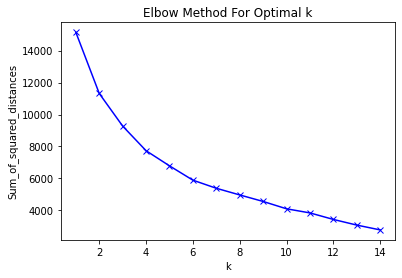

In [ ]:
# Below is a plot of sum of squared distances for k in the range specified above.
# If the plot looks like an arm, then the elbow on the arm is optimal k.

#plt.figure(figsize=(15,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbows appear to be at 2, 4 or 6, however, since the graph is vague, we will turn to the silhouette score.

### Sillhouette Scores

"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters." (wikipedia)

In [ ]:
sscores = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit_predict(X)
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    labels = km.labels_
    sscores.append(metrics.silhouette_score(X, labels, metric='euclidean'))

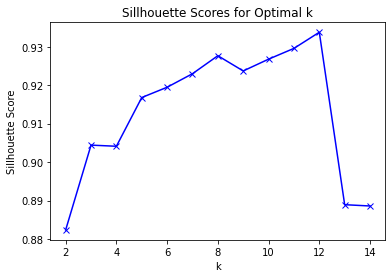

In [ ]:
plt.plot(K, sscores, 'bx-')
plt.xlabel('k')
plt.ylabel('Sillhouette Score')
plt.title('Sillhouette Scores for Optimal k')
plt.show()

Optimal k appears to be 12.

In [ ]:
def cluster_eval(x, n):
    km = KMeans(n_clusters=n, random_state=42).fit_predict(x)
    print('Bins:', np.bincount(km))
    km = KMeans(n_clusters=n, random_state=42).fit(x)
    labels = km.labels_
    print('Sillouhette Score:', metrics.silhouette_score(x, labels, metric='euclidean'))

In [ ]:
cluster_eval(X_norm, 2)

Bins: [4814 3658]
Sillouhette Score: 0.3290556140454752


In [ ]:
cluster_eval(X_norm, 3)

Bins: [4514 2297 1661]
Sillouhette Score: 0.3745870013512944


In [ ]:
cluster_eval(X_norm, 8)

Bins: [1942 1037 2095  454 1059  700  625  560]
Sillouhette Score: 0.47925759642446863


In [ ]:
cluster_eval(X_norm, 12)

Bins: [ 624  900  812 1016 1795  491  398  555  346  742  441  352]
Sillouhette Score: 0.5279153322661218


#### Cluster # Selection

In [ ]:
k = 12

In [ ]:
km = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
print(np.bincount(km))

[ 624  900  812 1016 1795  491  398  555  346  742  441  352]


#### Append Cluster Labels to Dataframe

In [ ]:
dfc = df.copy()

In [ ]:
dfc.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,6,5547521,12,8,1148,1600.0,677,0,95.666667,195.218914,1173,0,200.000000,404.854471,4.953564e+02,3.605214,2.919748e+05,7.080794e+05,3062075.0,3.0,5547521.0,5.043201e+05,8.984476e+05,3062075.0,3.0,5507400.0,7.867714e+05,1.175918e+06,3360042.0,80454.0,0,0,0,0,264,172,2.163128,1.442086,0,1173,130.857143,286.076438,81839.728571,0,0,0,1,0,0,0,0,0,137.400000,95.666667,200.000000,0,0,0,0,0,0,12,1148,8,1600,8192,62852,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,56719,6,1191,5,2,935,314.0,935,0,187.000000,418.144712,314,0,157.000000,222.031529,1.048699e+06,5877.413938,1.985000e+02,2.464433e+02,636.0,4.0,1191.0,2.977500e+02,4.296141e+02,922.0,4.0,636.0,6.360000e+02,0.000000e+00,636.0,636.0,0,0,0,0,124,40,4198.152813,1679.261125,0,935,156.125000,333.342568,111117.267900,0,0,1,1,0,0,0,1,0,178.428571,187.000000,157.000000,0,0,0,0,0,0,5,935,2,314,65535,32768,1,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,80,6,5263499,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.759951,1.754500e+06,3.028889e+06,5251953.0,29.0,5263499.0,2.631750e+06,3.705527e+06,5251953.0,11546.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,72,32,0.569963,0.189988,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,1,0,8192,29200,0,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,3389,6,1676278,8,7,1128,1581.0,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1.616080e+03,8.948396,1.197341e+05,2.449952e+05,952053.0,42.0,1676278.0,2.394683e+05,3.865538e+05,1110837.0,54.0,1568197.0,2.613662e+05,3.388635e+05,952053.0,108728.0,0,0,0,0,168,148,4.772478,4.175918,0,1173,169.312500,317.731274,100953.162500,0,0,0,1,0,0,0,0,0,180.600000,141.000000,225.857143,0,0,0,0,0,0,8,1128,7,1581,8192,62872,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,443,6,64348464,15,15,1247,6286.0,918,0,83.133333,238.109779,1460,0,419.066667,618.265254,1.170657e+02,0.466212,2.218913e+06,4.115819e+06,10000000.0,5.0,64300000.0,4.596319e+06,4.985422e+06,10000000.0,76.0,60200000.0,4.300739e+06,5.137524e+06,10000000.0,33.0,0,0,0,0,312,384,0.233106,0.233106,0,1460,243.000000,484.859980,235089.200000,0,0,0,1,0,0,0,0,1,251.100000,83.133333,419.066667,0,0,0,0,0,0,15,1247,15,6286,8192,126,9,20,34143.83333,43644.61527,123233.0,16282.0,10000000.0,895.996205,10000000.0,9999341.0,Benign


In [ ]:
# fix indices (if using sampled data)
dfc.reset_index(inplace=True, drop=True)

In [ ]:
dfc.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,6,5547521,12,8,1148,1600.0,677,0,95.666667,195.218914,1173,0,200.000000,404.854471,4.953564e+02,3.605214,2.919748e+05,7.080794e+05,3062075.0,3.0,5547521.0,5.043201e+05,8.984476e+05,3062075.0,3.0,5507400.0,7.867714e+05,1.175918e+06,3360042.0,80454.0,0,0,0,0,264,172,2.163128,1.442086,0,1173,130.857143,286.076438,81839.728571,0,0,0,1,0,0,0,0,0,137.400000,95.666667,200.000000,0,0,0,0,0,0,12,1148,8,1600,8192,62852,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,56719,6,1191,5,2,935,314.0,935,0,187.000000,418.144712,314,0,157.000000,222.031529,1.048699e+06,5877.413938,1.985000e+02,2.464433e+02,636.0,4.0,1191.0,2.977500e+02,4.296141e+02,922.0,4.0,636.0,6.360000e+02,0.000000e+00,636.0,636.0,0,0,0,0,124,40,4198.152813,1679.261125,0,935,156.125000,333.342568,111117.267900,0,0,1,1,0,0,0,1,0,178.428571,187.000000,157.000000,0,0,0,0,0,0,5,935,2,314,65535,32768,1,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,80,6,5263499,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.759951,1.754500e+06,3.028889e+06,5251953.0,29.0,5263499.0,2.631750e+06,3.705527e+06,5251953.0,11546.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,72,32,0.569963,0.189988,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,1,0,8192,29200,0,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,3389,6,1676278,8,7,1128,1581.0,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1.616080e+03,8.948396,1.197341e+05,2.449952e+05,952053.0,42.0,1676278.0,2.394683e+05,3.865538e+05,1110837.0,54.0,1568197.0,2.613662e+05,3.388635e+05,952053.0,108728.0,0,0,0,0,168,148,4.772478,4.175918,0,1173,169.312500,317.731274,100953.162500,0,0,0,1,0,0,0,0,0,180.600000,141.000000,225.857143,0,0,0,0,0,0,8,1128,7,1581,8192,62872,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,443,6,64348464,15,15,1247,6286.0,918,0,83.133333,238.109779,1460,0,419.066667,618.265254,1.170657e+02,0.466212,2.218913e+06,4.115819e+06,10000000.0,5.0,64300000.0,4.596319e+06,4.985422e+06,10000000.0,76.0,60200000.0,4.300739e+06,5.137524e+06,10000000.0,33.0,0,0,0,0,312,384,0.233106,0.233106,0,1460,243.000000,484.859980,235089.200000,0,0,0,1,0,0,0,0,1,251.100000,83.133333,419.066667,0,0,0,0,0,0,15,1247,15,6286,8192,126,9,20,34143.83333,43644.61527,123233.0,16282.0,10000000.0,895.996205,10000000.0,9999341.0,Benign


In [ ]:
# load cluster labels into tmp dataframe
tmp = pd.DataFrame(km)

In [ ]:
# append labels
dfc['Cluster'] = tmp

In [ ]:
# same as above code, for later use
def append_cluster_labels(data, x, k):
    km = KMeans(n_clusters=k, random_state=42).fit_predict(x)
    tmp1 = data.copy()
    tmp1.reset_index(inplace=True, drop=True)
    tmp2 = pd.DataFrame(km)
    tmp1['Cluster'] = tmp2
    return tmp1

### Investigate Clusters

In [ ]:
dfc[['Label', 'Cluster']]

,Label,Cluster
0,Benign,4
1,Benign,2
2,Benign,9
3,Benign,4
4,Benign,4
...,...,...
8467,SQL Injection,11
8468,SQL Injection,11
8469,SQL Injection,9
8470,SQL Injection,11


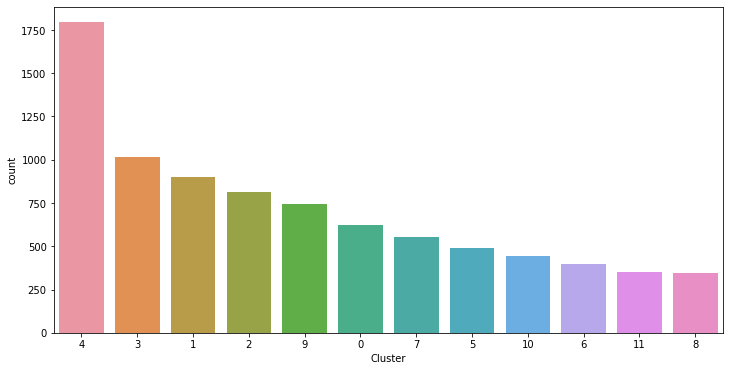

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="Cluster", order=dfc.Cluster.value_counts().index, data=dfc)

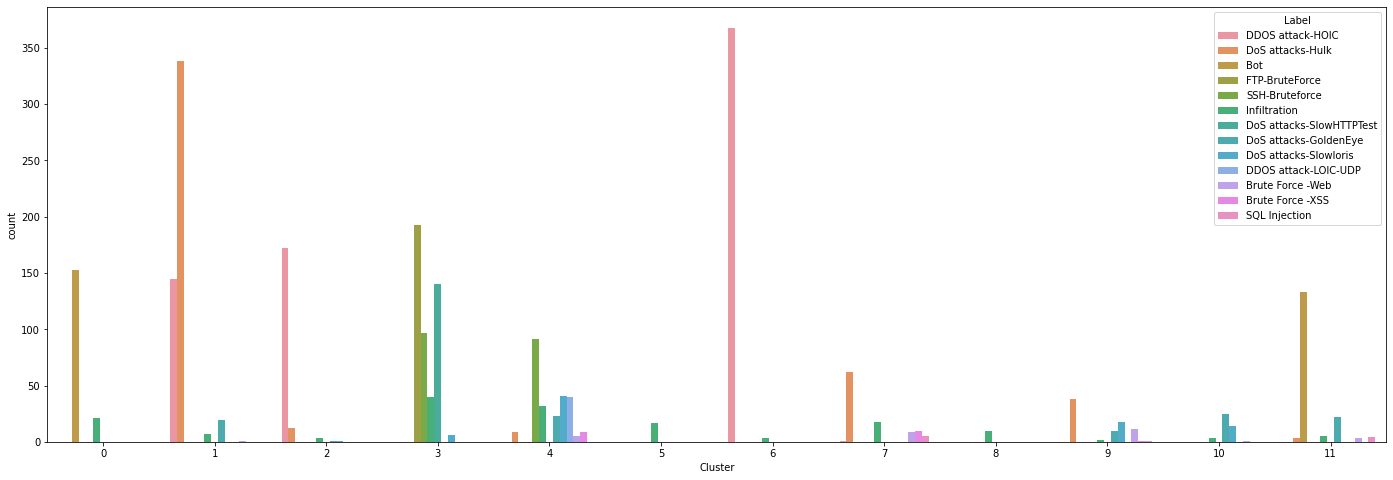

In [ ]:
plt.figure(figsize=(24,8))
#ax = sns.countplot(x="Cluster", hue="Label", data=dfc)
ax = sns.countplot(x="Cluster", hue="Label", data=dfc[dfc.Label != 'Benign'])

We can see that many of the attack types are distributed among multiple clusters, meaning these clusters don't tell us much about our label.

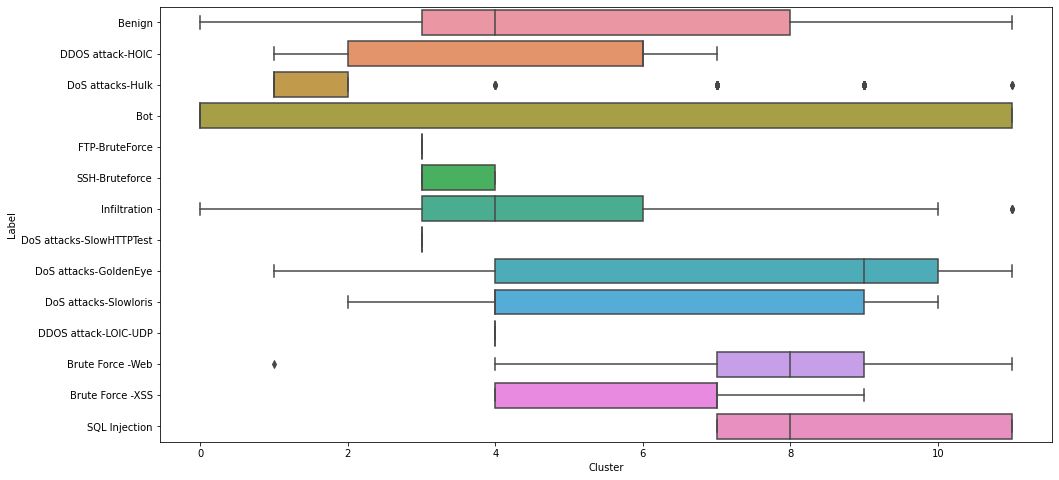

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster', y='Label', data=dfc)

Let's try 8 clusters, as that seemed to be a peak sillouette score.

In [ ]:
dfc = append_cluster_labels(dfc, X_norm, 8)

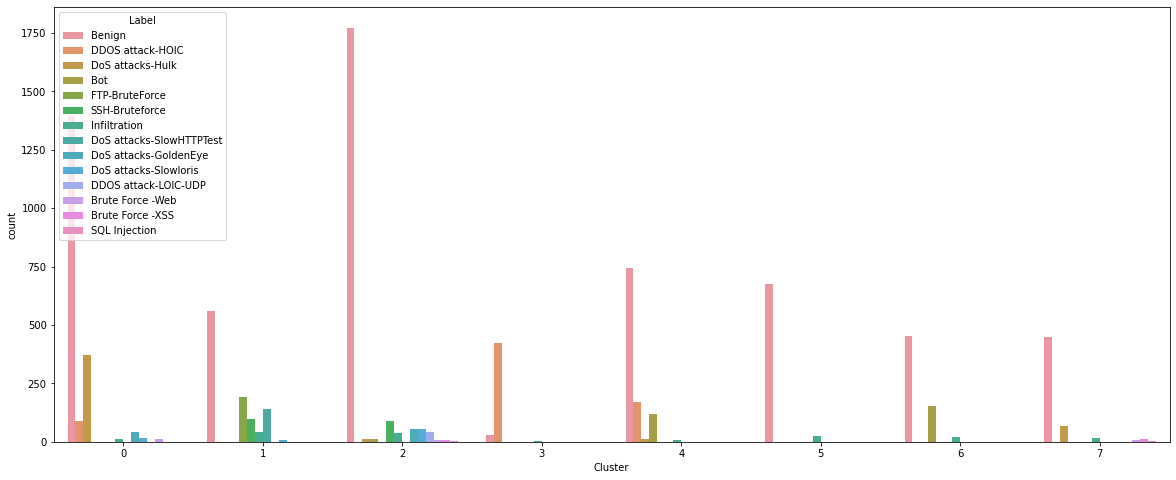

In [ ]:
plt.figure(figsize=(20,8))
#ax = sns.countplot(x="Cluster", hue="Label", data=dfc)
ax = sns.countplot(x="Cluster", hue="Label", data=dfc)

Still inconclusive.

For fun, let's see if using two clusters would seperate benign events from attacks.

In [ ]:
dfc = append_cluster_labels(dfc, X_norm, 2)

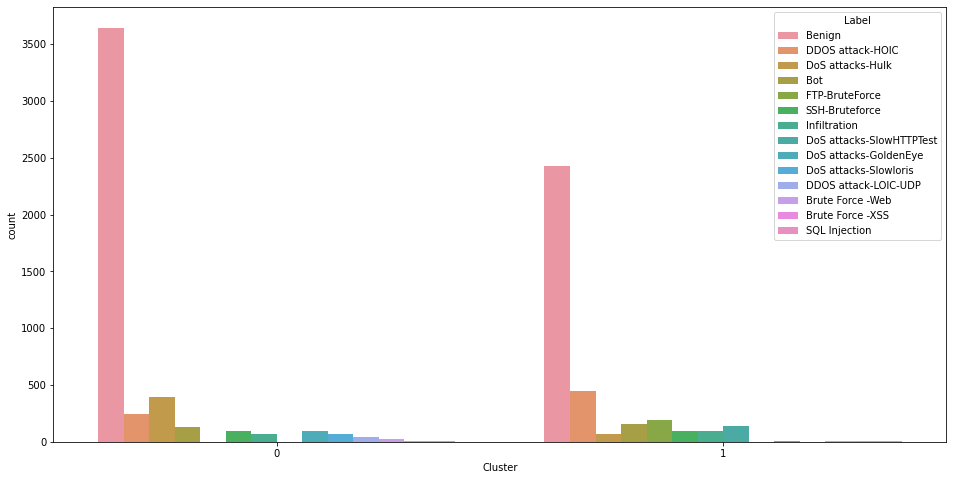

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x="Cluster", hue="Label", data=dfc)
#ax = sns.countplot(x="Cluster", hue="Label", data=dfc[dfc.Label != 'Benign'])

No luck. Benign events are almost evenly distributed between the two clusters.

## Threat Distribution

In [ ]:
print(df.Label.value_counts(dropna=False))

Benign                      6076
DDOS attack-HOIC             686
DoS attacks-Hulk             462
Bot                          286
FTP-BruteForce               193
SSH-Bruteforce               188
Infiltration                 161
DoS attacks-SlowHTTPTest     140
DoS attacks-GoldenEye        100
DoS attacks-Slowloris         80
DDOS attack-LOIC-UDP          40
Brute Force -Web              30
Brute Force -XSS              20
SQL Injection                 10
Name: Label, dtype: int64


### All Events

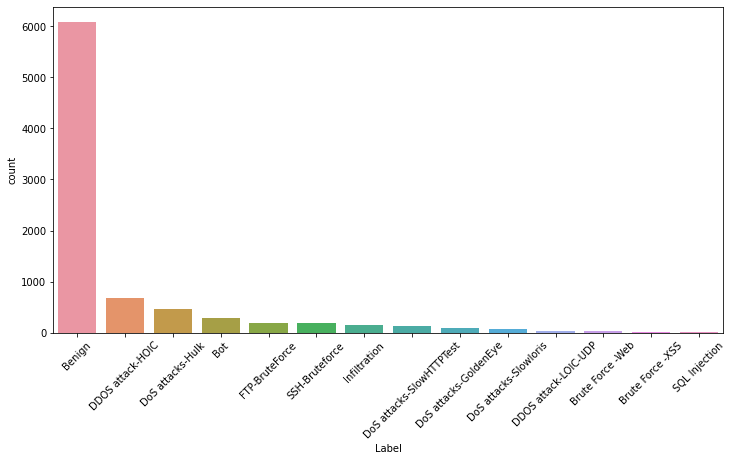

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.countplot(x="Label", order=df.Label.value_counts().index, data=df, orient='h')

### Malicious Events

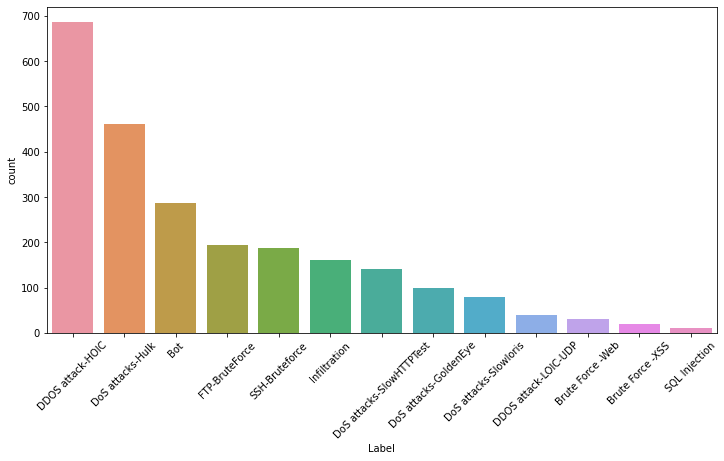

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.countplot(x="Label", order=df[df.Label != "Benign"].Label.value_counts().index, data=df)

Let's binarize the events into benign vs malicious.

## Binarize Events

In [ ]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,6,5547521,12,8,1148,1600.0,677,0,95.666667,195.218914,1173,0,200.000000,404.854471,4.953564e+02,3.605214,2.919748e+05,7.080794e+05,3062075.0,3.0,5547521.0,5.043201e+05,8.984476e+05,3062075.0,3.0,5507400.0,7.867714e+05,1.175918e+06,3360042.0,80454.0,0,0,0,0,264,172,2.163128,1.442086,0,1173,130.857143,286.076438,81839.728571,0,0,0,1,0,0,0,0,0,137.400000,95.666667,200.000000,0,0,0,0,0,0,12,1148,8,1600,8192,62852,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,56719,6,1191,5,2,935,314.0,935,0,187.000000,418.144712,314,0,157.000000,222.031529,1.048699e+06,5877.413938,1.985000e+02,2.464433e+02,636.0,4.0,1191.0,2.977500e+02,4.296141e+02,922.0,4.0,636.0,6.360000e+02,0.000000e+00,636.0,636.0,0,0,0,0,124,40,4198.152813,1679.261125,0,935,156.125000,333.342568,111117.267900,0,0,1,1,0,0,0,1,0,178.428571,187.000000,157.000000,0,0,0,0,0,0,5,935,2,314,65535,32768,1,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,80,6,5263499,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.759951,1.754500e+06,3.028889e+06,5251953.0,29.0,5263499.0,2.631750e+06,3.705527e+06,5251953.0,11546.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,72,32,0.569963,0.189988,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,1,0,8192,29200,0,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,3389,6,1676278,8,7,1128,1581.0,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1.616080e+03,8.948396,1.197341e+05,2.449952e+05,952053.0,42.0,1676278.0,2.394683e+05,3.865538e+05,1110837.0,54.0,1568197.0,2.613662e+05,3.388635e+05,952053.0,108728.0,0,0,0,0,168,148,4.772478,4.175918,0,1173,169.312500,317.731274,100953.162500,0,0,0,1,0,0,0,0,0,180.600000,141.000000,225.857143,0,0,0,0,0,0,8,1128,7,1581,8192,62872,5,20,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,443,6,64348464,15,15,1247,6286.0,918,0,83.133333,238.109779,1460,0,419.066667,618.265254,1.170657e+02,0.466212,2.218913e+06,4.115819e+06,10000000.0,5.0,64300000.0,4.596319e+06,4.985422e+06,10000000.0,76.0,60200000.0,4.300739e+06,5.137524e+06,10000000.0,33.0,0,0,0,0,312,384,0.233106,0.233106,0,1460,243.000000,484.859980,235089.200000,0,0,0,1,0,0,0,0,1,251.100000,83.133333,419.066667,0,0,0,0,0,0,15,1247,15,6286,8192,126,9,20,34143.83333,43644.61527,123233.0,16282.0,10000000.0,895.996205,10000000.0,9999341.0,Benign


In [ ]:
df.Label.value_counts()

Benign                      6076
DDOS attack-HOIC             686
DoS attacks-Hulk             462
Bot                          286
FTP-BruteForce               193
SSH-Bruteforce               188
Infiltration                 161
DoS attacks-SlowHTTPTest     140
DoS attacks-GoldenEye        100
DoS attacks-Slowloris         80
DDOS attack-LOIC-UDP          40
Brute Force -Web              30
Brute Force -XSS              20
SQL Injection                 10
Name: Label, dtype: int64

In [ ]:
dfb = df.copy()

In [ ]:
def binarize_events(x):
    if (x != 'Benign'):
        x = 'Malicious'
    return x

In [ ]:
dfb.Label = dfb.Label.apply(binarize_events)

In [ ]:
dfb.Label.value_counts(dropna=False)

Benign       6076
Malicious    2396
Name: Label, dtype: int64

### Countplot

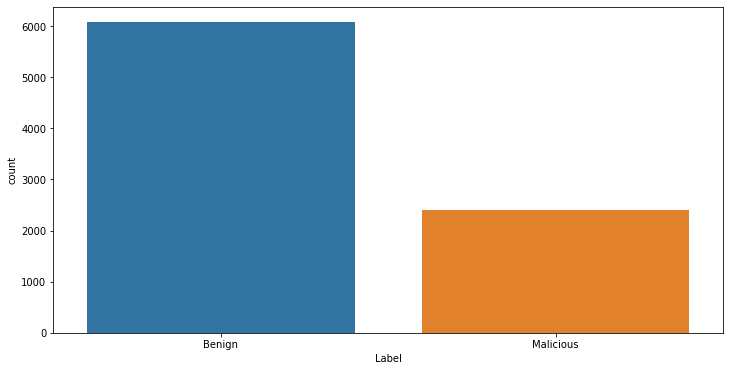

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="Label", order=dfb.Label.value_counts().index, data=dfb)

Now that the data is cleaned, let's run baseline tests to see which models perform the best.

# Modelling I

In [ ]:
def model_results(X, Y, model, name):
    start_time1 = time.time()

    if (name == 'MLP'):
        X = normalize(X)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    prob_train = model.predict_proba(X_train)
    prob_test = model.predict_proba(X_test)

    print('{} train accuracy: {}'.format(name, accuracy_score(y_train, y_pred_train)))
    print('{} test accuracy:  {}'.format(name, accuracy_score(y_test, y_pred_test)))

    print('{} train f1 score: {}'.format(name, f1_score(y_train, y_pred_train, average='weighted'))) # average = !micro/!macro/weighted/samples
    print('{} test f1 score:  {}'.format(name, f1_score(y_test, y_pred_test, average='weighted')))

    #print('{} train roc score: {}'.format(name, roc_auc_score(y_train, y_pred_train)))
    #print('{} test roc score:  {}'.format(name, roc_auc_score(y_test, y_pred_test)))

    print('{} train log loss: {}'.format(name, log_loss(y_train, prob_train)))
    print('{} test log loss:  {}'.format(name, log_loss(y_test, prob_test)))

    print(name, 'time:          ', (time.time() - start_time1), '\n')

In [ ]:
def baseline_test(X, Y, model_select):
    if (model_select == 'MLP' or model_select == 'ALL'):
        mlp = MLPClassifier(random_state=42)
        model_results(X, Y, mlp, 'MLP')

    if (model_select == 'LR' or model_select == 'ALL'):
        lr = LogisticRegression()
        model_results(X, Y, lr, 'LR ')

    if (model_select == 'RFC' or model_select == 'ALL'):
        rfc = RandomForestClassifier(random_state=42)
        model_results(X, Y, rfc, 'RFC')

    if (model_select == 'KNN' or model_select == 'ALL'):
        knn = KNeighborsClassifier()
        model_results(X, Y, knn, 'KNN')

    #if (model_select == 'GBC' or model_select == 'ALL'):
        #gbc = GradientBoostingClassifier(random_state=42)
        #model_results(X, Y, gbc, 'GBC')

## Full Classification

In [ ]:
X = df.drop(columns=['Label'])
Y = df.Label

In [ ]:
#rfc = RandomForestClassifier(random_state=42)
#rfc.fit(X,Y)
#print(cross_val_score(rfc, X, Y, cv=5))

[0.96283186 0.96224189 0.95985832 0.96103896 0.95985832]


In [ ]:
#X = normalize(X)

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.9330087059170724
MLP test accuracy:  0.9297935103244838
MLP train f1 score: 0.9189692167289721
MLP test f1 score:  0.9174090093847089
MLP train log loss: 0.2348130909489589
MLP test log loss:  0.24951140526860285
MLP time:           10.578983545303345 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.7239191382617678
LR  test accuracy:  0.7244837758112095
LR  train f1 score: 0.63471623853159
LR  test f1 score:  0.6299679094902803
LR  train log loss: 1.5080145885472571
LR  test log loss:  1.6000189166114505
LR  time:           2.0133168697357178 

RFC train accuracy: 0.9893758300132802
RFC test accuracy:  0.9587020648967551
RFC train f1 score: 0.9884791045545618
RFC test f1 score:  0.9536488050419318
RFC train log loss: 0.03956284732301229
RFC test log loss:  0.34726694454824747
RFC time:           1.9910063743591309 

KNN train accuracy: 0.9517485613103143
KNN test accuracy:  0.943952802359882
KNN train f1 score: 0.9421228573113739
KNN test f1 score:  0.9331356225477604
KNN train log loss: 0.10287657213997986
KNN test log loss:  1.0350726496904075
KNN time:           1.0220296382904053 

--- 15.622477531433105 seconds total ---


It seems that the random forest classifier is the best performer here.

## Binary Classification

In [ ]:
X = dfb.drop(columns=['Label'])
Y = dfb.Label

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.9434853179873101
MLP test accuracy:  0.9445427728613569
MLP train f1 score: 0.9422599616250649
MLP test f1 score:  0.9433230108240236
MLP train log loss: 0.1645548138348427
MLP test log loss:  0.17183491853053193
MLP time:           9.272108316421509 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.7792533569426
LR  test accuracy:  0.7887905604719764
LR  train f1 score: 0.7679669257206919
LR  test f1 score:  0.7778711411194281
LR  train log loss: 0.48621115369670004
LR  test log loss:  0.4910540812214069
LR  time:           0.3681826591491699 

RFC train accuracy: 1.0
RFC test accuracy:  0.9740412979351032
RFC train f1 score: 1.0
RFC test f1 score:  0.9739067452290994
RFC train log loss: 0.019813528327643416
RFC test log loss:  0.25856033242189336
RFC time:           1.6317439079284668 

KNN train accuracy: 0.9665043529585362
KNN test accuracy:  0.9634218289085545
KNN train f1 score: 0.9661697813810601
KNN test f1 score:  0.9630043252907523
KNN train log loss: 0.07421331296200055
KNN test log loss:  0.7073812533550704
KNN time:           1.0177440643310547 

--- 12.29333209991455 seconds total ---


Random forest classifier is the clear leader here as well. Models only performed slightly worse when performing a full classification of attack types.

# Feature Engineering

## PCA

Let's see if dimensionality reduction can improve the performance of our baseline models.

https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['Label']))

In [ ]:
# 95% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(df_scaled)
reduced = pca.transform(df_scaled)

### Ideal # of Components

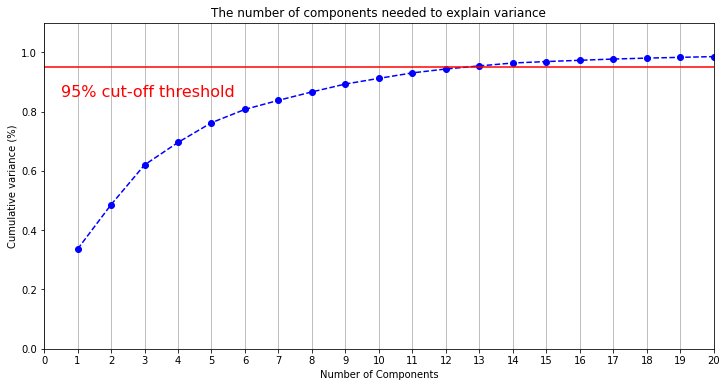

In [ ]:
pca = PCA().fit(df_scaled)

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 79, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.xlim(0.0,20.0)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 21, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Looks like 13 components is ideal.

### Transform X

In [ ]:
X = df.drop(columns=['Label'])
Y = df.Label

In [ ]:
X.shape

(8472, 78)

In [ ]:
X = PCA(n_components=12).fit_transform(X)

In [ ]:
X.shape

(8472, 12)

### Baseline Models w/ PCA (Full Classification)

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.7379371403275786
MLP test accuracy:  0.7333333333333333
MLP train f1 score: 0.6310271755335859
MLP test f1 score:  0.6242246410811404
MLP train log loss: 0.8996413263619294
MLP test log loss:  0.9498290164933763
MLP time:           8.679226160049438 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.701195219123506
LR  test accuracy:  0.6926253687315634
LR  train f1 score: 0.6014777203028443
LR  test f1 score:  0.5944362638257409
LR  train log loss: 1.9013881171112337
LR  test log loss:  1.9670156177328462
LR  time:           1.2462992668151855 

RFC train accuracy: 0.9893758300132802
RFC test accuracy:  0.9333333333333333
RFC train f1 score: 0.9885921833705056
RFC test f1 score:  0.926414153671234
RFC train log loss: 0.05469100541373095
RFC test log loss:  0.7449940088849811
RFC time:           2.3463284969329834 

KNN train accuracy: 0.9113176921941862
KNN test accuracy:  0.8985250737463126
KNN train f1 score: 0.9003252020449288
KNN test f1 score:  0.8856385149258542
KNN train log loss: 0.18178480032043282
KNN test log loss:  1.3945905900312205
KNN time:           0.39989686012268066 

--- 12.674707412719727 seconds total ---


In [ ]:
X = dfb.drop(columns=['Label'])
Y = dfb.Label

In [ ]:
X.shape

(8472, 78)

In [ ]:
X = PCA(n_components=13).fit_transform(X)

In [ ]:
X.shape

(8472, 13)

### Baseline Models w/ PCA (Binary Classification)

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.732182381584772
MLP test accuracy:  0.727433628318584
MLP train f1 score: 0.6520963958954233
MLP test f1 score:  0.6419246732737786
MLP train log loss: 0.45559599516177174
MLP test log loss:  0.4648390672377998
MLP time:           7.127831697463989 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.45152722443559096
LR  test accuracy:  0.4424778761061947
LR  train f1 score: 0.4257087127236281
LR  test f1 score:  0.413237966398105
LR  train log loss: 0.6605252705296775
LR  test log loss:  0.664176520858076
LR  time:           0.3114299774169922 

RFC train accuracy: 1.0
RFC test accuracy:  0.9569321533923304
RFC train f1 score: 1.0
RFC test f1 score:  0.956577074192285
RFC train log loss: 0.02891974826051656
RFC test log loss:  0.33450940224564174
RFC time:           1.8261747360229492 

KNN train accuracy: 0.9513058875608676
KNN test accuracy:  0.9510324483775812
KNN train f1 score: 0.9507453366258944
KNN test f1 score:  0.9503129160517695
KNN train log loss: 0.10148183088908935
KNN test log loss:  0.8696747995621797
KNN time:           0.4154055118560791 

--- 9.683000802993774 seconds total ---


Overall, we don't see any improvement with PCA, and random forest seems to be overfitting as well.

## Feature Correlation to Label

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [ ]:
def label_encode(data, cols):
    for col in cols:
        le = preprocessing.LabelEncoder()
        le.fit(data[col])
        data[col] = le.transform(data[col])
    return data

In [ ]:
encode_cols = ['Label']

In [ ]:
df_le = df.copy()

In [ ]:
df_le = label_encode(df_le, encode_cols)

In [ ]:
cor = df_le.corr()

In [ ]:
pd.set_option('display.max_rows', None)

# correlation with output variable
cor_target = abs(cor['Label'])

# selecting highly correlated features
relevant_features = cor_target[cor_target > 0.15] # <- ADJUST # FEATURES
print(relevant_features.sort_values(ascending=False))

pd.set_option('display.max_rows', 15)

Label                1.000000
Fwd Seg Size Min     0.551217
Bwd Pkts/s           0.427155
Flow Pkts/s          0.353654
Fwd Pkts/s           0.251854
Dst Port             0.236060
Pkt Size Avg         0.234144
Fwd Seg Size Avg     0.232463
Fwd Pkt Len Mean     0.232463
Pkt Len Std          0.213511
Pkt Len Mean         0.210860
Fwd Pkt Len Max      0.206118
Fwd Pkt Len Std      0.206093
Pkt Len Max          0.202043
Init Bwd Win Byts    0.199354
Bwd Pkt Len Mean     0.193589
Bwd Seg Size Avg     0.193589
Bwd Pkt Len Min      0.188862
Protocol             0.188660
Pkt Len Var          0.167425
Bwd Pkt Len Std      0.151453
Name: Label, dtype: float64


In [ ]:
top_features = ['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
                'Fwd Pkt Len Mean', 'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Pkt Len Mean',
                'Pkt Len Std', 'Fwd Pkt Len Std', 'Protocol', 'Fwd Pkt Len Max',
                'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Init Bwd Win Byts',
                'Bwd Pkt Len Min', 'Pkt Len Min']

In [ ]:
df_top = df[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
                'Fwd Pkt Len Mean', 'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Pkt Len Mean',
                'Pkt Len Std', 'Fwd Pkt Len Std', 'Protocol', 'Fwd Pkt Len Max',
                'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Init Bwd Win Byts',
                'Bwd Pkt Len Min', 'Pkt Len Min', 'Label']]

In [ ]:
df_top_b = dfb[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
                'Fwd Pkt Len Mean', 'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Pkt Len Mean',
                'Pkt Len Std', 'Fwd Pkt Len Std', 'Protocol', 'Fwd Pkt Len Max',
                'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Init Bwd Win Byts',
                'Bwd Pkt Len Min', 'Pkt Len Min', 'Label']]

In [ ]:
df_top.head()

,Fwd Seg Size Min,Bwd Pkts/s,Flow Pkts/s,Fwd Seg Size Avg,Fwd Pkt Len Mean,Pkt Size Avg,Dst Port,Fwd Pkts/s,Pkt Len Mean,Pkt Len Std,Fwd Pkt Len Std,Protocol,Fwd Pkt Len Max,Bwd Pkt Len Mean,Bwd Seg Size Avg,Pkt Len Max,Init Bwd Win Byts,Bwd Pkt Len Min,Pkt Len Min,Label
0,20,1.442086,3.605214,95.666667,95.666667,137.400000,3389,2.163128,130.857143,286.076438,195.218914,6,677,200.000000,200.000000,1173,62852,0,0,Benign
1,20,1679.261125,5877.413938,187.000000,187.000000,178.428571,56719,4198.152813,156.125000,333.342568,418.144712,6,935,157.000000,157.000000,935,32768,0,0,Benign
2,20,0.189988,0.759951,0.000000,0.000000,0.000000,80,0.569963,0.000000,0.000000,0.000000,6,0,0.000000,0.000000,0,29200,0,0,Benign
3,20,4.175918,8.948396,141.000000,141.000000,180.600000,3389,4.772478,169.312500,317.731274,222.623321,6,661,225.857143,225.857143,1173,62872,0,0,Benign
4,20,0.233106,0.466212,83.133333,83.133333,251.100000,443,0.233106,243.000000,484.859980,238.109779,6,918,419.066667,419.066667,1460,126,0,0,Benign


### Feature Correlation Heatmap

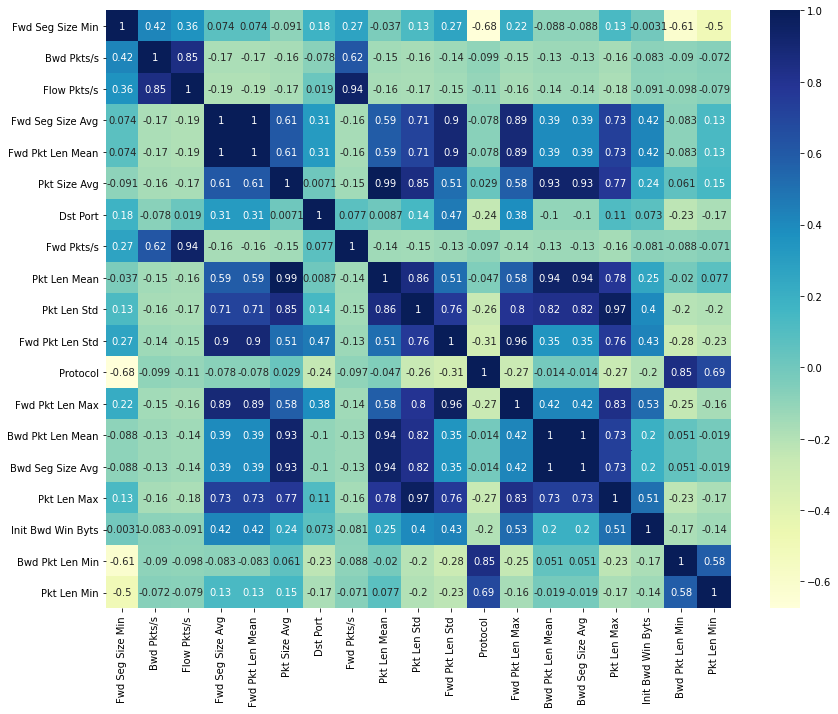

In [ ]:
plt.figure(figsize=(14,11))
sns.heatmap(df_top.corr(), annot=True, cmap="YlGnBu")

We have a high density of feature-to-feature correlation. Let's reduce the feature count until we no longer have this problem.

In [ ]:
pd.set_option('display.max_rows', None)

# correlation with output variable
cor_target = abs(cor['Label'])

# selecting highly correlated features
relevant_features = cor_target[cor_target > 0.191] # <- ADJUST # FEATURES
print(relevant_features.sort_values(ascending=False))

pd.set_option('display.max_rows', 15)

Label                1.000000
Fwd Seg Size Min     0.551217
Bwd Pkts/s           0.427155
Flow Pkts/s          0.353654
Fwd Pkts/s           0.251854
Dst Port             0.236060
Pkt Size Avg         0.234144
Fwd Seg Size Avg     0.232463
Fwd Pkt Len Mean     0.232463
Pkt Len Std          0.213511
Pkt Len Mean         0.210860
Fwd Pkt Len Max      0.206118
Fwd Pkt Len Std      0.206093
Pkt Len Max          0.202043
Init Bwd Win Byts    0.199354
Bwd Seg Size Avg     0.193589
Bwd Pkt Len Mean     0.193589
Name: Label, dtype: float64


In [ ]:
df_top = df[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
                'Fwd Pkt Len Mean', 'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s',
                'Pkt Len Mean', 'Pkt Len Std', 'Fwd Pkt Len Std', 'Protocol', 'Label']]

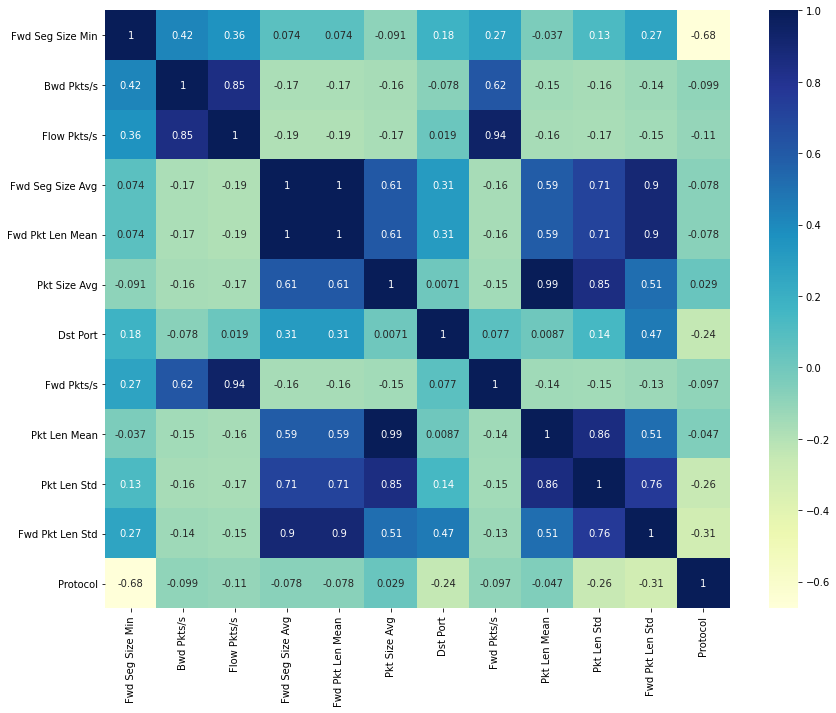

In [ ]:
plt.figure(figsize=(14,11))
sns.heatmap(df_top.corr(), annot=True, cmap="YlGnBu")

### Selected Feature Info

1. __Fwd Seg Size Min:__ Minimum segment size observed in the forward direction

2. __Bwd Pkts/s:__        Number of backward packets per second

3. __Fwd Seg Size Avg:__  Average size observed in the forward direction

4. __Fwd Pkt Len Mean:__  Mean size of packet in forward direction

5. __Pkt Size Avg:__      Average size of packet

6. __Dst Port:__          Port

7. __Fwd Pkts/s:__        Number of forward packets per second

8. __Pkt Len Mean:__      Mean length of a flow

9. __Pkt Len Std:__       Standard deviation length of a flow

10. __Fwd Pkt Len Std:__  Standard deviation size of packet in forward direction

11. __Protocol:__         Protocol

Fwd Pkt Len Mean 1.0 corr with Fwd Seg Size Avg and has less correlation with label. Remove.

Fwd Pkt Size Avg .99 corr with Pkt Len Mean and has less correlation with label. Remove.

In [ ]:
df_top = df[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
             'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Protocol', 'Label']]

In [ ]:
dfb_top = dfb[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
             'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Protocol', 'Label']]

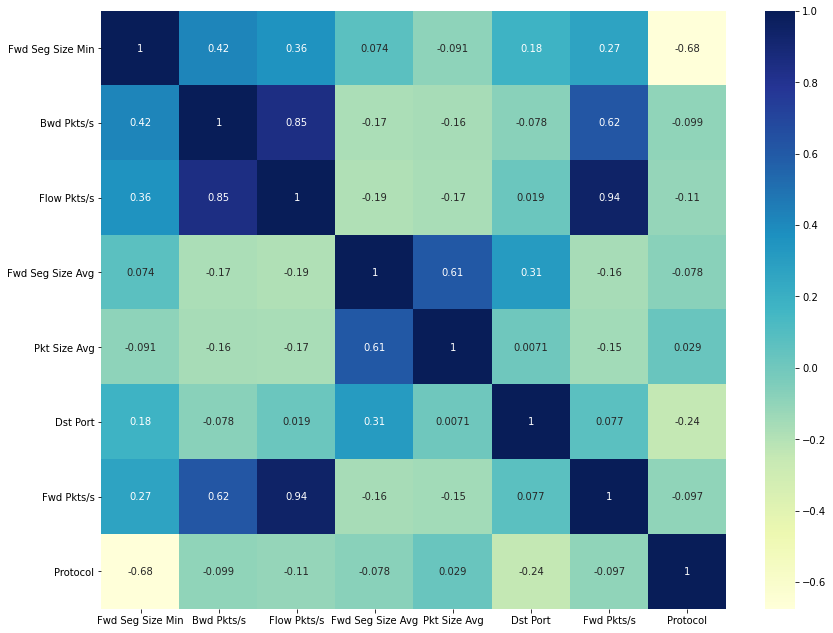

In [ ]:
# heatmap
plt.figure(figsize=(14,11))
sns.heatmap(df_top.corr(), annot=True, cmap="YlGnBu")

### Combine Correlated Features (reduced all performance)

In [ ]:
#df_top2 = df_top.copy()
#dfb_top2 = dfb_top.copy()

In [ ]:
#df_top2['Pkts/s'] = df_top2['Flow Pkts/s'] * df_top2['Bwd Pkts/s']
#df_top2.drop(columns=['Flow Pkts/s', 'Bwd Pkts/s'], inplace=True)

#dfb_top2['Pkts/s'] = dfb_top2['Flow Pkts/s'] * dfb_top2['Bwd Pkts/s']
#dfb_top2.drop(columns=['Flow Pkts/s', 'Bwd Pkts/s'], inplace=True)

In [ ]:
#df_top2['Pkts/s'] = df_top2['Flow Pkts/s'] * df_top2['Fwd Pkts/s']
#df_top2.drop(columns=['Flow Pkts/s', 'Fwd Pkts/s'], inplace=True)

#dfb_top2['Pkts/s'] = dfb_top2['Flow Pkts/s'] * dfb_top2['Fwd Pkts/s']
#dfb_top2.drop(columns=['Flow Pkts/s', 'Fwd Pkts/s'], inplace=True)

In [ ]:
# heatmap
#plt.figure(figsize=(14,11))
#sns.heatmap(df_top2.corr(), annot=True, cmap="YlGnBu")

### Final Heatmap w/ Label

In [ ]:
df_le_top = df_le[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Fwd Seg Size Avg',
             'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Protocol', 'Label']]

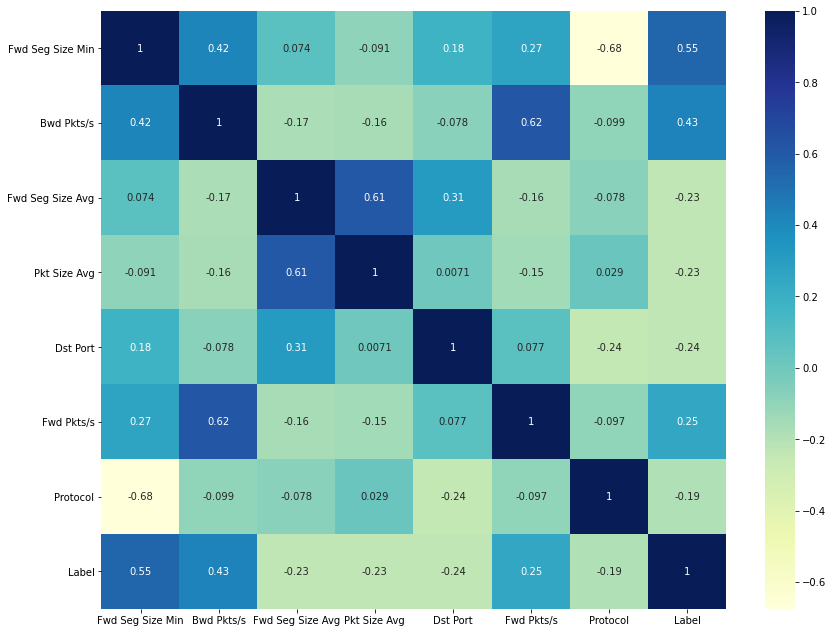

In [ ]:
# heatmap
plt.figure(figsize=(14,11))
sns.heatmap(df_le_top.corr(), annot=True, cmap="YlGnBu")

Looks like we have a solid feature set with no major correlation issues.

Now that we have a reduced number of features, let's explore them a little further.

# Exploration II

## Feature Distributions

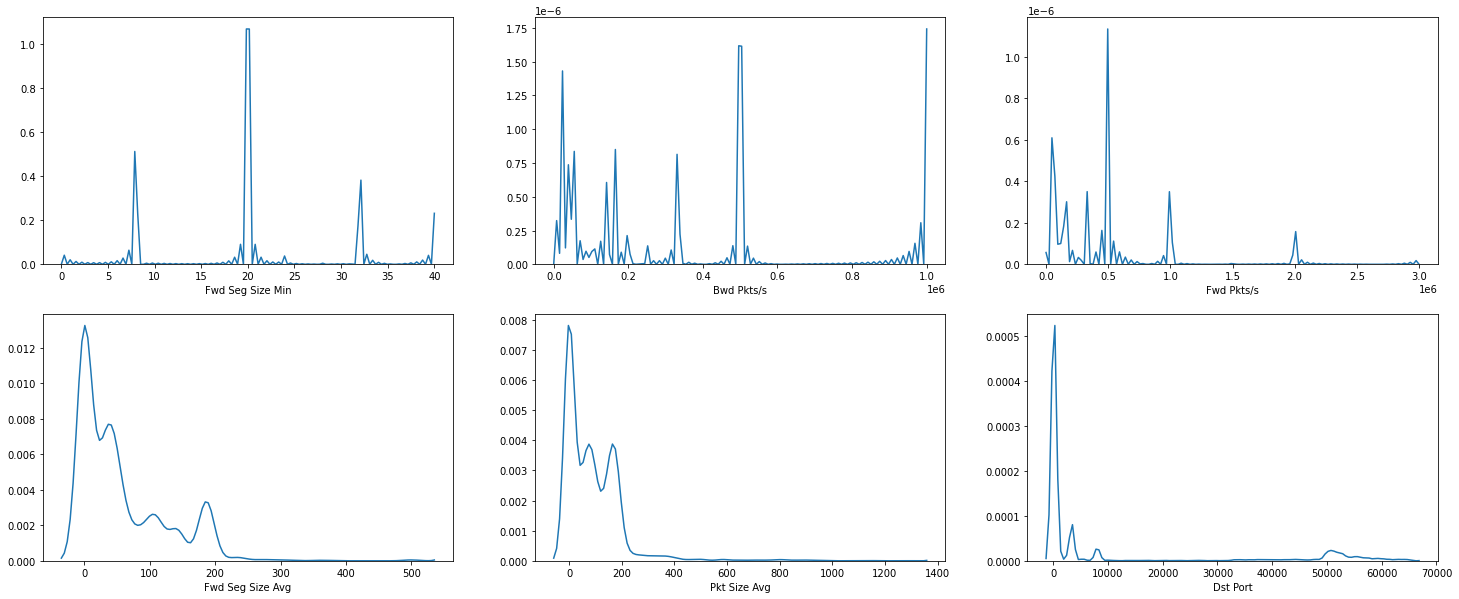

In [ ]:
plt.figure(figsize=(25,10))

plt.subplot(231)
sns.distplot(df['Fwd Seg Size Min'], hist=False)

plt.subplot(232)
sns.distplot(df['Bwd Pkts/s'], hist=False)

plt.subplot(233)
sns.distplot(df['Fwd Pkts/s'], hist=False)

plt.subplot(234)
sns.distplot(df['Fwd Seg Size Avg'], hist=False)

plt.subplot(235)
sns.distplot(df['Pkt Size Avg'], hist=False)

plt.subplot(236)
sns.distplot(df['Dst Port'], hist=False)

We can see spikes in these feature distributions, likely due to different attack types.

Let’s investigate Fwd Seg Size Min for possible correlation between these spikes and the different attack types.

## Analyzing Spikes

In [ ]:
features = ['Fwd Seg Size Min']

In [ ]:
attacks = ['Benign', 'DDOS attack-HOIC', 'DoS attacks-Hulk', 'Bot',
                'FTP-BruteForce', 'SSH-Bruteforce', 'Infilteration',
                'DoS attacks-SlowHTTPTest', 'DoS attacks-GoldenEye',
                'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP',
                'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection']

In [ ]:
for feature in features:
    print('{}:'.format(feature))
    for attack in attacks:
        print(attack, 'mean:', df[df.Label == attack][feature].mean())

Fwd Seg Size Min:
Benign mean: 17.601711652402898
DDOS attack-HOIC mean: 20.0
DoS attacks-Hulk mean: 31.974025974025974
Bot mean: 20.0
FTP-BruteForce mean: 40.0
SSH-Bruteforce mean: 32.0
Infilteration mean: nan
DoS attacks-SlowHTTPTest mean: 40.0
DoS attacks-GoldenEye mean: 32.0
DoS attacks-Slowloris mean: 33.8
DDOS attack-LOIC-UDP mean: 8.0
Brute Force -Web mean: 16.133333333333333
Brute Force -XSS mean: 19.4
SQL Injection mean: 20.0


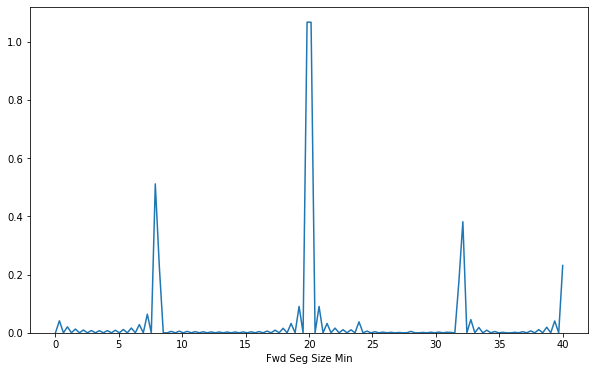

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(df['Fwd Seg Size Min'], hist=False)

Both DDoS HOIC and Botnet means are ~20, explaining the large spike at ~20

DDoS Hulk, SSH BruteForce, DDoS GoldenEye means are ~32, explaining the spike at ~32

FTP Bruteforce and DoS SlowHTTPTest with means of 40 explains the spike at ~40


## Benign vs. Malicious Distributions

In [ ]:
def feature_dist_compare(df1, df2, name1, name2):
    plt.figure(figsize=(25,10))

    plt.subplot(231)
    sns.distplot(df1['Fwd Seg Size Min'], hist=False, label=name1)
    sns.distplot(df2['Fwd Seg Size Min'], hist=False, color='r', label=name2)

    plt.subplot(232)
    sns.distplot(df1['Bwd Pkts/s'], hist=False, label=name1)
    sns.distplot(df2['Bwd Pkts/s'], hist=False, color='r', label=name2)

    plt.subplot(233)
    sns.distplot(df1['Fwd Pkts/s'], hist=False, label=name1)
    sns.distplot(df2['Fwd Pkts/s'], hist=False, color='r', label=name2)

    plt.subplot(234)
    sns.distplot(df1['Fwd Seg Size Avg'], hist=False, label=name1)
    sns.distplot(df2['Fwd Seg Size Avg'], hist=False, color='r', label=name2)

    plt.subplot(235)
    sns.distplot(df1['Pkt Size Avg'], hist=False, label=name1)
    sns.distplot(df2['Pkt Size Avg'], hist=False, color='r', label=name2)

    plt.subplot(236)
    sns.distplot(df1['Dst Port'], hist=False, label=name1)
    sns.distplot(df2['Dst Port'], hist=False, color='r', label=name2)

In [ ]:
df_benign = dfb[dfb.Label == 'Benign']
df_malicious = dfb[dfb.Label == 'Malicious']

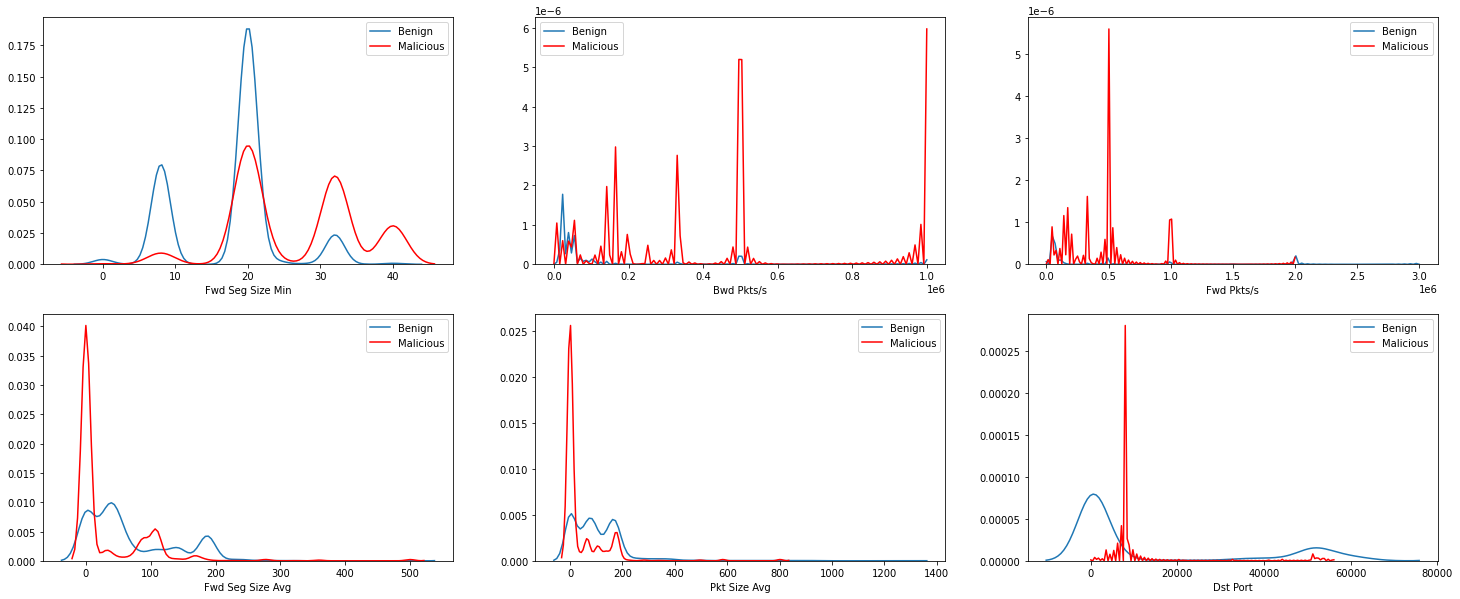

In [ ]:
feature_dist_compare(df_benign, df_malicious, 'Benign', 'Malicious')

We can see some clear differences in the feature distributions of benign events vs attacks, especially in 'Dst Port' and 'Fwd Seg Size Avg'.

# Modelling II

## Full Classification w/ Selected Features

In [ ]:
# use top features from now on
#df_all = df.copy()
#df = df_top.copy()

In [ ]:
X = df_top.drop(columns=['Label'])
Y = df_top.Label

In [ ]:
#X = normalize(X)

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.876198908071418
MLP test accuracy:  0.8820058997050148
MLP train f1 score: 0.8447096265754228
MLP test f1 score:  0.8509249696885173
MLP train log loss: 0.3787671009552749
MLP test log loss:  0.37936941516872724
MLP time:           8.395405054092407 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.6957355762136639
LR  test accuracy:  0.6926253687315634
LR  train f1 score: 0.6117622635881128
LR  test f1 score:  0.6100021958931389
LR  train log loss: 1.74746163192919
LR  test log loss:  1.8256464701902249
LR  time:           1.5649051666259766 

RFC train accuracy: 0.987900250848458
RFC test accuracy:  0.9504424778761061
RFC train f1 score: 0.9869924082208034
RFC test f1 score:  0.9433335268339349
RFC train log loss: 0.04323691483109786
RFC test log loss:  0.5103674855213116
RFC time:           1.209207534790039 

KNN train accuracy: 0.9359598642467168
KNN test accuracy:  0.9209439528023599
KNN train f1 score: 0.9265061160859912
KNN test f1 score:  0.9099002106004328
KNN train log loss: 0.13288499139512638
KNN test log loss:  1.2464180071236775
KNN time:           0.421583890914917 

--- 11.594319343566895 seconds total ---


### Precision-Recall Curve

In [ ]:
def prc(X, Y):
    #mlp = MLPClassifier(random_state=42)
    #lr = LogisticRegression()
    rfc = RandomForestClassifier(random_state=42)
    #knn = KNeighborsClassifier()
    #gbc = GradientBoostingClassifier(random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

    rfc.fit(X_train, y_train)
    probas = rfc.predict_proba(X_test)
    skplt.metrics.plot_precision_recall_curve(y_test, probas, figsize=(15,10))
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


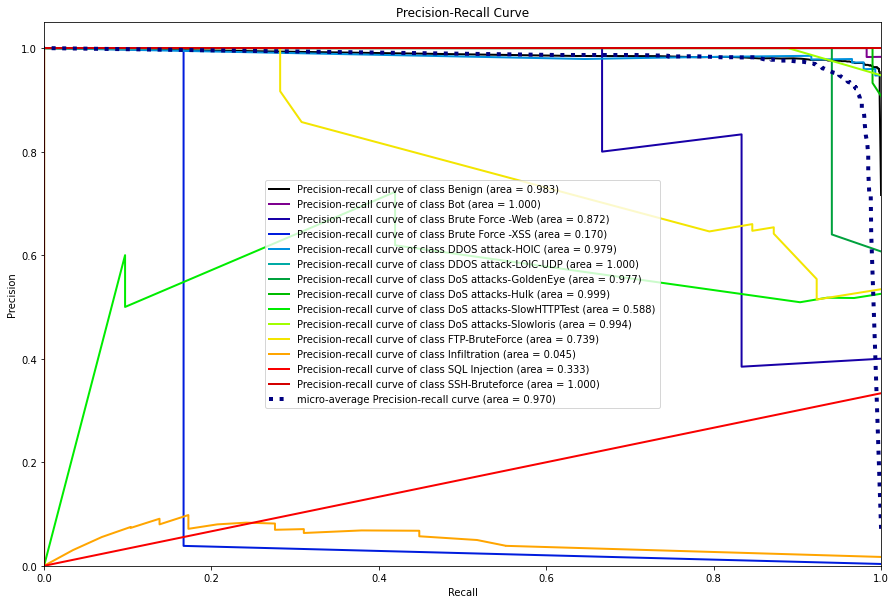

In [ ]:
prc(X, Y)

### Confusion Matrix

In [ ]:
def cmm(X, Y, model):
    predictions = cross_val_predict(model, X, Y)

    plt.figure(figsize=(15,10))
    skplt.metrics.plot_confusion_matrix(Y, predictions, normalize=True, x_tick_rotation=45, figsize=(15,10))

In [ ]:
def cm(X, Y):
    #mlp = MLPClassifier(random_state=42)
    #lr = LogisticRegression()
    rfc = RandomForestClassifier(random_state=42)
    #knn = KNeighborsClassifier()
    #gbc = GradientBoostingClassifier(random_state=42)

    predictions = cross_val_predict(rfc, X, Y)

    plt.figure(figsize=(15,10))
    skplt.metrics.plot_confusion_matrix(Y, predictions, normalize=True, x_tick_rotation=45, figsize=(15,10))

<Figure size 1080x720 with 0 Axes>

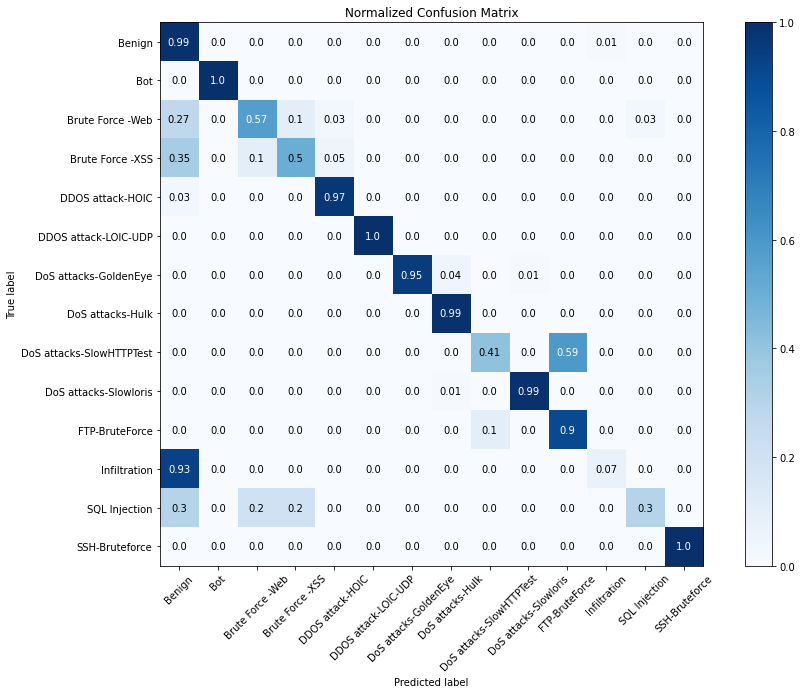

In [ ]:
cm(X, Y)

We can see that some classes seem to be underperforming. This could be due to lower sample sizes of these classes.

Infiltration's extremely poor performance stands out, especially it doesn't suffer from a low sample size like the others.

## Binary Classification w/ Selected Features

In [ ]:
#dfb_all = dfb.copy()
#dfb = dfb_top.copy()

In [ ]:
X = dfb_top.drop(columns=['Label'])
Y = dfb_top.Label

In [ ]:
#X = normalize(X)

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.9188431459347794
MLP test accuracy:  0.9274336283185841
MLP train f1 score: 0.9170265620453927
MLP test f1 score:  0.925923725254131
MLP train log loss: 0.27118358647940366
MLP test log loss:  0.26551404780077037
MLP time:           7.001194477081299 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.7898775269293198
LR  test accuracy:  0.799410029498525
LR  train f1 score: 0.7952622096428338
LR  test f1 score:  0.8053916887594299
LR  train log loss: 0.42866311801225393
LR  test log loss:  0.41183067993305905
LR  time:           0.3181924819946289 

RFC train accuracy: 0.9985244208351778
RFC test accuracy:  0.9687315634218289
RFC train f1 score: 0.9985241870800814
RFC test f1 score:  0.968473766194399
RFC train log loss: 0.022608552286306153
RFC test log loss:  0.3214273012728284
RFC time:           0.9525713920593262 

KNN train accuracy: 0.9641434262948207
KNN test accuracy:  0.9646017699115044
KNN train f1 score: 0.9638483974434358
KNN test f1 score:  0.9643705931351365
KNN train log loss: 0.07736066656965598
KNN test log loss:  0.7282039872699955
KNN time:           0.4253995418548584 

--- 8.699621677398682 seconds total ---


### Precision-Recall Curve

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


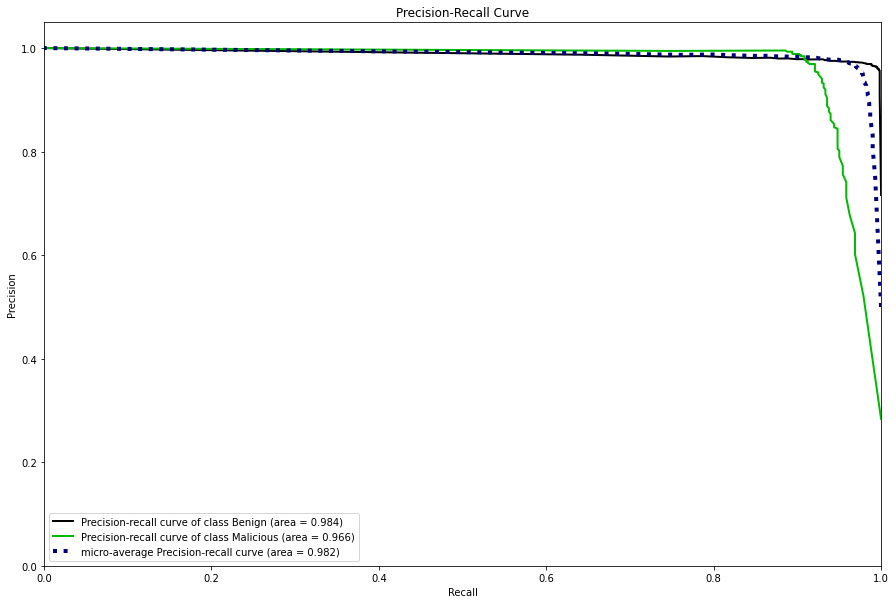

In [ ]:
prc(X, Y)

### Confusion Matrix

<Figure size 1080x720 with 0 Axes>

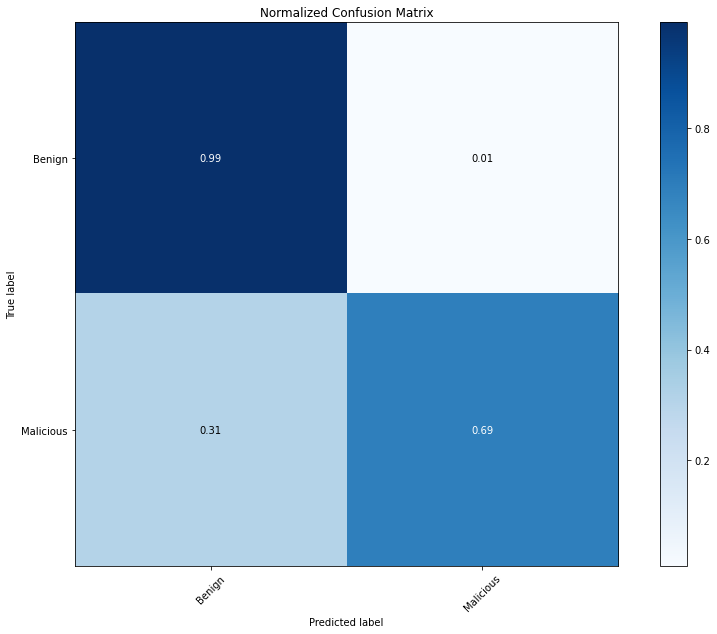

In [ ]:
cm(X, Y)

# Exploration III

## Benign vs. Infiltration

Let's try to find out why infiltration is difficult to predict.

### Distributions

In [ ]:
df_benign = df[df.Label == 'Benign']
df_infil = df[df.Label == 'Infiltration']
df_bot = df[df.Label == 'Bot']

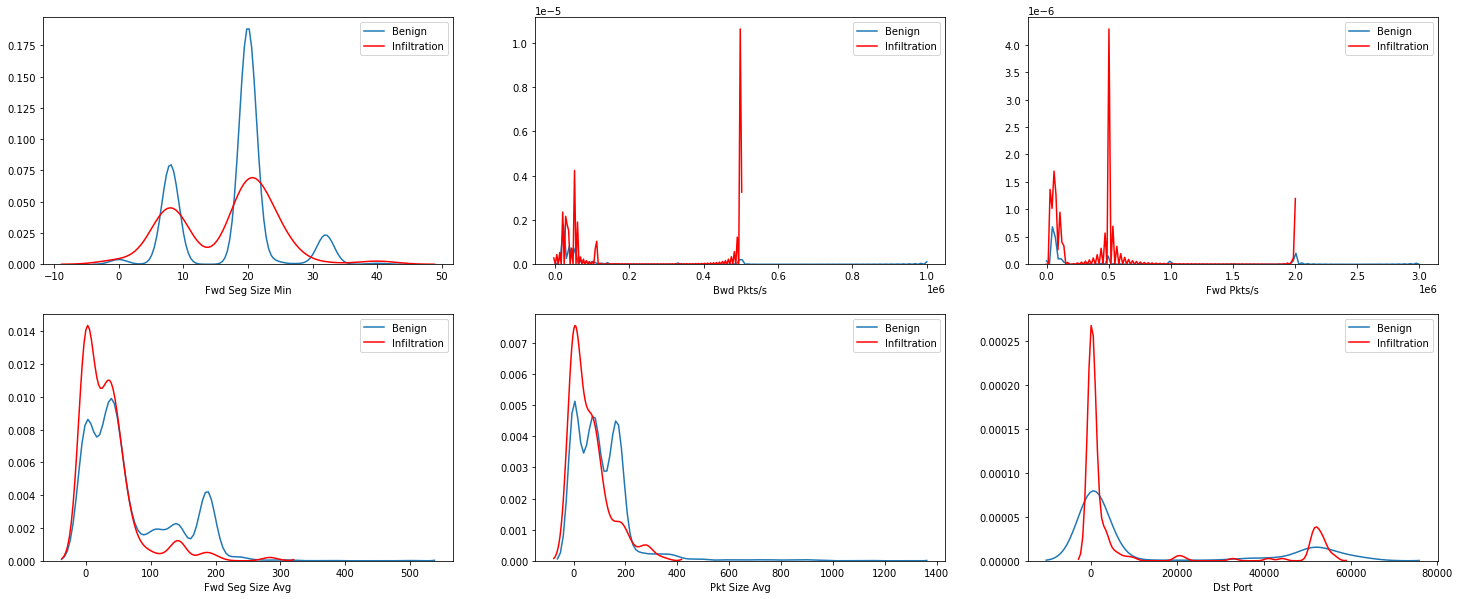

In [ ]:
feature_dist_compare(df_benign, df_infil, 'Benign', 'Infiltration')

The feature distributions of benign events and infiltration attacks are quite similar, which is likely leading to the model's uncertainty between the two.

### Confusion Matrix

In [ ]:
frames = [df_benign, df_infil]

In [ ]:
tmp_df = pd.concat(frames)

In [ ]:
tmp_df.Label.value_counts()

Benign          6076
Infiltration     161
Name: Label, dtype: int64

In [ ]:
X = tmp_df.drop(columns=['Label'])
Y = tmp_df.Label

<Figure size 1080x720 with 0 Axes>

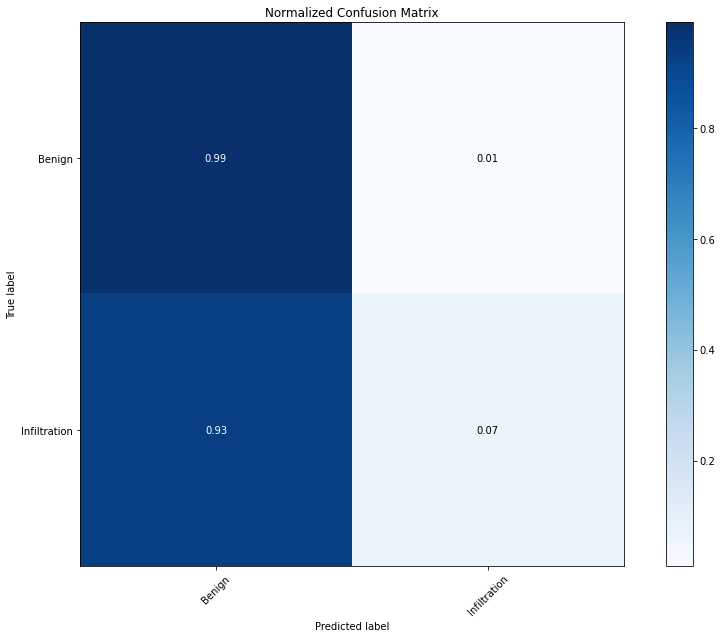

In [ ]:
cm(X, Y)

The model struggles to differentiate between benign and infiltration, labelling most infiltration attacks as benign.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


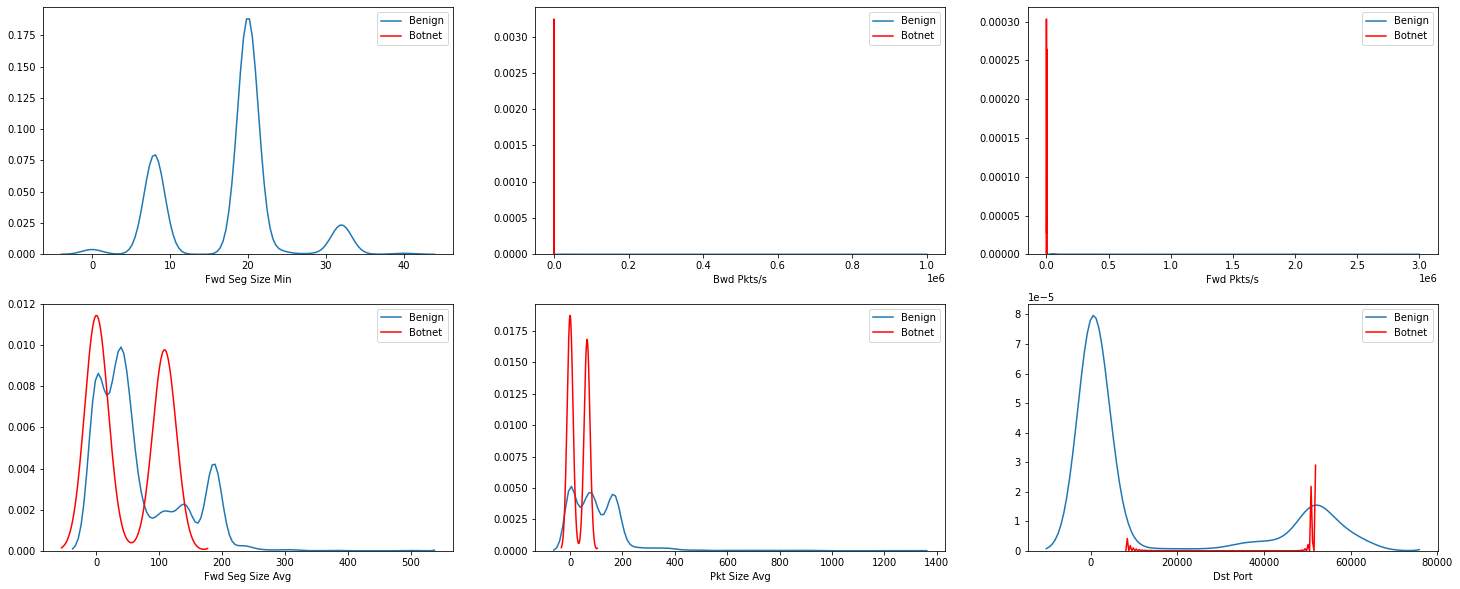

In [ ]:
feature_dist_compare(df_benign, df_bot, 'Benign', 'Botnet')

In [ ]:
frames = [df_benign, df_bot]

In [ ]:
tmp_df = pd.concat(frames)

In [ ]:
X = tmp_df.drop(columns=['Label'])
Y = tmp_df.Label

<Figure size 1080x720 with 0 Axes>

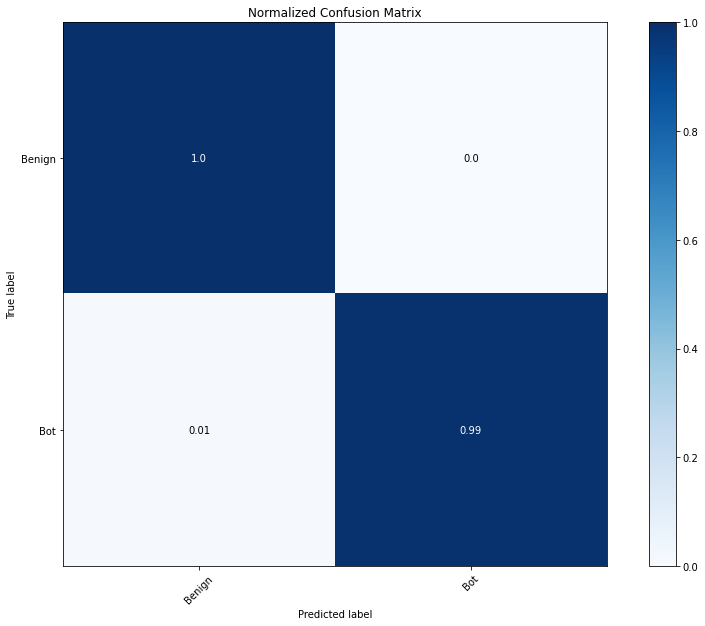

In [ ]:
cm(X, Y)

In contrast, we can see that the model can differentiate between benign and botnet quite accurately.

## Difference Score (Inconclusive)

Meant to show the similarity of features between benign events and each attack type.

In [ ]:
features = ['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
                'Fwd Pkt Len Mean', 'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Pkt Len Mean',
                'Pkt Len Std', 'Fwd Pkt Len Std', 'Protocol', 'Fwd Pkt Len Max',
                'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Init Bwd Win Byts',
                'Bwd Pkt Len Min', 'Pkt Len Min']

#features = ['Fwd Seg Size Min']

attacks = ['DDOS attack-HOIC', 'DoS attacks-Hulk', 'Bot', 'Infiltration',
           'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP',
           'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'SSH-Bruteforce',
           'FTP-BruteForce', 'DoS attacks-SlowHTTPTest']

In [ ]:
#if ('df_full' not in locals()):
#    df_og = df_ps.copy()
#else:
#    df_og = df_full.copy()

In [ ]:
dscores = []
for attack in attacks:
    dscore = 0
    for feature in features:
        dscore += abs(df[df.Label == 'Benign'][feature].mean() - df[df.Label == attack][feature].mean())
    dscores.append(dscore)

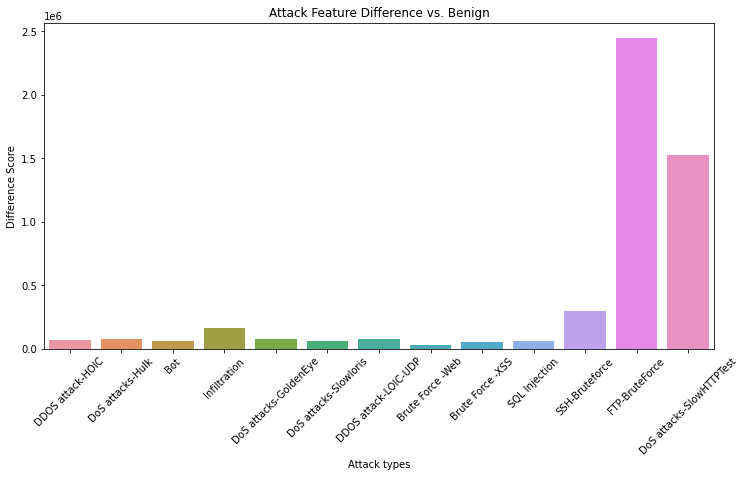

In [ ]:
sns.barplot(attacks, dscores)
plt.xlabel('Attack types')
plt.ylabel('Difference Score')
plt.title('Attack Feature Difference vs. Benign')
plt.xticks(rotation=45)
plt.show()

Now that we've identified the model's shortcomings, let's see if we can address them.

# Model Optimization

## Models Without Low-Performing Classes

For curiosity's sake, let's see how performance increases without the less-represented attack types.

In [ ]:
weak_classes = ['Brute Force -Web', 'Brute Force -XSS', 'DoS attacks-SlowHTTPTest',
           'Infiltration', 'SQL Injection', 'DDOS attack-HOIC']

### Full Classification

In [ ]:
df_fix = df.copy()

for c in weak_classes:
    df_fix = df_fix[df_fix.Label != c]

In [ ]:
df_fix.shape

(7425, 79)

In [ ]:
X = df_fix.drop(columns=['Label'])
Y = df_fix.Label

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.9643097643097643
MLP test accuracy:  0.9622895622895623
MLP train f1 score: 0.961283701731117
MLP test f1 score:  0.9572187917612631
MLP train log loss: 0.10708155716716991
MLP test log loss:  0.1176402386025017
MLP time:           9.073646306991577 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.851010101010101
LR  test accuracy:  0.8619528619528619
LR  train f1 score: 0.7904922764846196
LR  test f1 score:  0.8047368733417829
LR  train log loss: 0.885415977094392
LR  test log loss:  0.854607468685294
LR  time:           1.457113265991211 

RFC train accuracy: 1.0
RFC test accuracy:  0.9973063973063973
RFC train f1 score: 1.0
RFC test f1 score:  0.9973176289725643
RFC train log loss: 0.003032821242608891
RFC test log loss:  0.00971026981464281
RFC time:           1.1625964641571045 

KNN train accuracy: 0.9841750841750841
KNN test accuracy:  0.9824915824915825
KNN train f1 score: 0.9840953215558607
KNN test f1 score:  0.9821728101671308
KNN train log loss: 0.032663990521789074
KNN test log loss:  0.2129213158546323
KNN time:           0.8878824710845947 

--- 12.584129810333252 seconds total ---


<Figure size 1080x720 with 0 Axes>

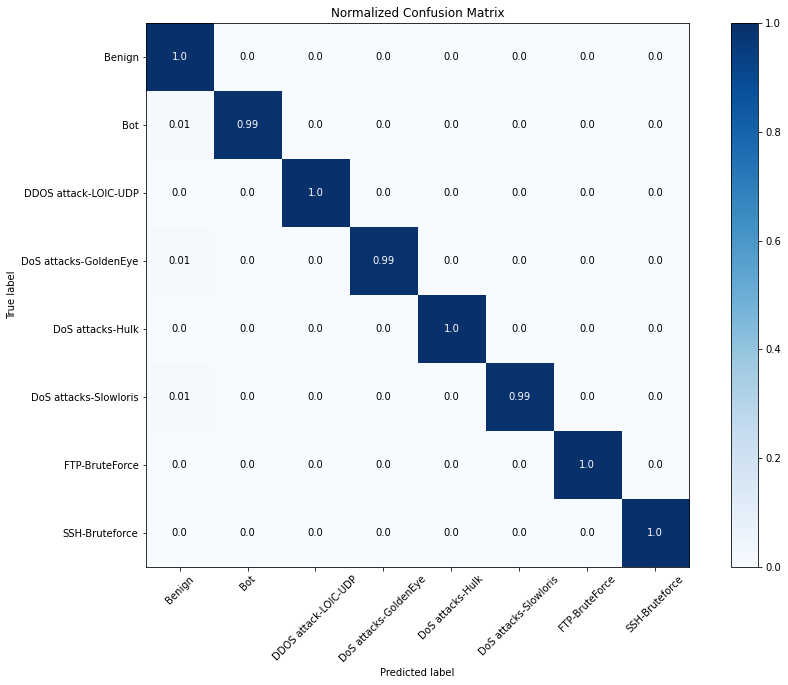

In [ ]:
cm(X, Y)

We see a great improvement in accuracy when ignoring the less-frequent attacks.

### Binary Classification

In [ ]:
dfb_fix = df_fix.copy()

In [ ]:
dfb_fix.Label = dfb_fix.Label.apply(binarize_events)

In [ ]:
dfb_fix.shape

(7425, 79)

In [ ]:
dfb_fix.Label.value_counts()

Benign       6076
Malicious    1349
Name: Label, dtype: int64

In [ ]:
X = dfb_fix.drop(columns=['Label'])
Y = dfb_fix.Label

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.9648148148148148
MLP test accuracy:  0.9616161616161616
MLP train f1 score: 0.9640633139965618
MLP test f1 score:  0.9607352734957597
MLP train log loss: 0.08514621372409845
MLP test log loss:  0.09079719299400517
MLP time:           8.257338285446167 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.85
LR  test accuracy:  0.8585858585858586
LR  train f1 score: 0.8236195976144423
LR  test f1 score:  0.8376083166692304
LR  train log loss: 0.36711780875222816
LR  test log loss:  0.3608211427014886
LR  time:           0.3574035167694092 

RFC train accuracy: 1.0
RFC test accuracy:  0.9966329966329966
RFC train f1 score: 1.0
RFC test f1 score:  0.9966403626999685
RFC train log loss: 0.00268292250461573
RFC test log loss:  0.007829567175414819
RFC time:           1.0346875190734863 

KNN train accuracy: 0.9851851851851852
KNN test accuracy:  0.9824915824915825
KNN train f1 score: 0.985195787937225
KNN test f1 score:  0.982413216107901
KNN train log loss: 0.03087716557211995
KNN test log loss:  0.21061182302217926
KNN time:           0.9051740169525146 

--- 10.55707573890686 seconds total ---


<Figure size 1080x720 with 0 Axes>

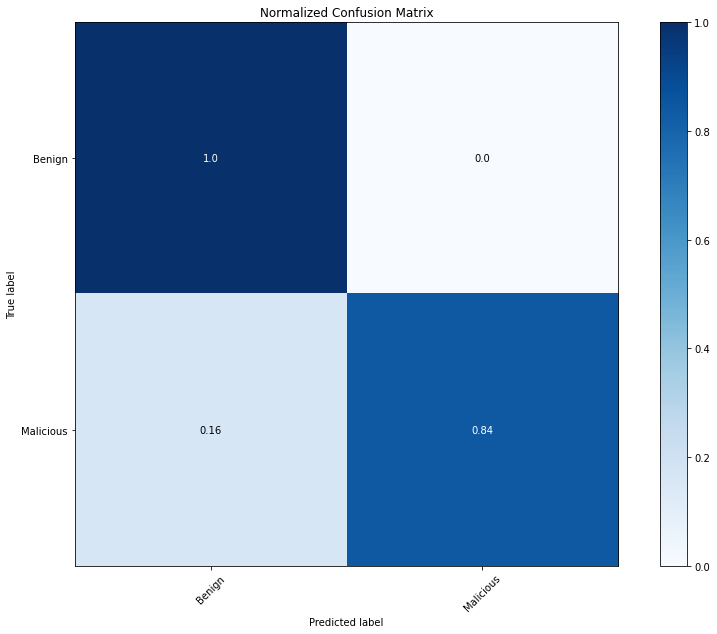

In [ ]:
cm(X, Y)

We see a great improvement in the binary classification as well, but it still isn't perfect.

Let's try sampling the data equally among attack types to remedy the class-imbalance.

## Models With Balanced Classes

In [ ]:
classes = ['Benign', 'DDOS attack-HOIC', 'DoS attacks-Hulk', 'Bot',
           'FTP-BruteForce', 'SSH-Bruteforce', 'Infilteration',
           'DoS attacks-SlowHTTPTest', 'DoS attacks-GoldenEye',
           'DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Brute Force -Web',
           'Brute Force -XSS', 'SQL Injection']

### Get Sample (From Original Dataset)

In [ ]:
# ideally should sample data from full dataset
# if not imported earlier, download/import here
if ('df_full' not in locals()):
    downloaded = drive.CreateFile({'id':"1-BmhLrys5f5hx15fTu3EcXJWD22c0vz8"})
    downloaded.GetContentFile('cyber_combined_v2.csv')
    df_full = pd.read_csv('cyber_combined_v2.csv')

In [ ]:
sampled_df = pd.DataFrame()

for c in classes:
    if (c == 'Benign'):
        tmp_df = df_full[df_full.Label == c].sample(n=4000, replace=True) # adjust n for benign samples
        sampled_df = pd.concat([sampled_df, tmp_df])
    else:
        tmp_df = df_full[df_full.Label == c].sample(n=400, replace=True) # adjust n for malicious samples
        sampled_df = pd.concat([sampled_df, tmp_df])

balanced_df = sampled_df.copy()

In [ ]:
balanced_df.shape

(9200, 80)

#### Clean Data

In [ ]:
balanced_df.Label.replace('Infilteration', 'Infiltration', inplace=True)

In [ ]:
balanced_df.drop(columns=['Timestamp'], inplace=True)

In [ ]:
balanced_df.replace([np.inf, -np.inf], np.nan, inplace=True)
balanced_df.dropna(inplace=True)

In [ ]:
balanced_df.Label.value_counts()

Benign                      3981
SSH-Bruteforce               400
DoS attacks-Slowloris        400
DoS attacks-GoldenEye        400
DDOS attack-HOIC             400
Brute Force -XSS             400
SQL Injection                400
Brute Force -Web             400
FTP-BruteForce               400
DoS attacks-Hulk             400
DDOS attack-LOIC-UDP         400
DoS attacks-SlowHTTPTest     400
Bot                          400
Infiltration                 398
Name: Label, dtype: int64

#### Select Features

In [ ]:
#balanced_df = balanced_df[['Fwd Seg Size Min', 'Bwd Pkts/s', 'Flow Pkts/s', 'Fwd Seg Size Avg',
#             'Pkt Size Avg', 'Dst Port', 'Fwd Pkts/s', 'Protocol', 'Label']]

### Countplot

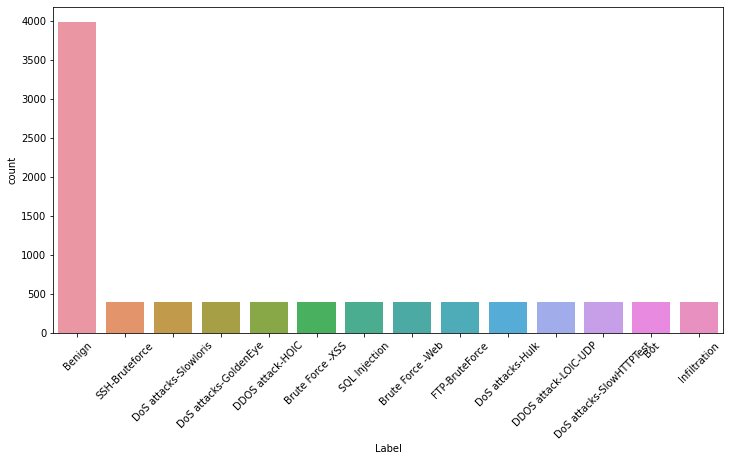

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.countplot(x="Label", order=balanced_df.Label.value_counts().index, data=balanced_df, orient='h')

### Full Classification

In [ ]:
X = balanced_df.drop(columns=['Label'])
Y = balanced_df.Label

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.8228244586681193
MLP test accuracy:  0.8006535947712419
MLP train f1 score: 0.798772655062912
MLP test f1 score:  0.7724358480595148
MLP train log loss: 0.48754152483391733
MLP test log loss:  0.5228508700332667
MLP time:           12.02039098739624 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.5105542693721912
LR  test accuracy:  0.5147058823529411
LR  train f1 score: 0.45259291380679056
LR  test f1 score:  0.45425049673128787
LR  train log loss: 1.719386059698774
LR  test log loss:  1.7924303033443942
LR  time:           1.8424439430236816 

RFC train accuracy: 0.9749421217486041
RFC test accuracy:  0.9210239651416122
RFC train f1 score: 0.9744923608015313
RFC test f1 score:  0.9096041786910148
RFC train log loss: 0.08095570815845352
RFC test log loss:  0.2605709498994512
RFC time:           2.261174201965332 

KNN train accuracy: 0.9113441372735939
KNN test accuracy:  0.8796296296296297
KNN train f1 score: 0.9011037224733697
KNN test f1 score:  0.8657774848495251
KNN train log loss: 0.7892423384297254
KNN test log loss:  2.225027841450424
KNN time:           1.1883831024169922 

--- 17.44355869293213 seconds total ---


<Figure size 1080x720 with 0 Axes>

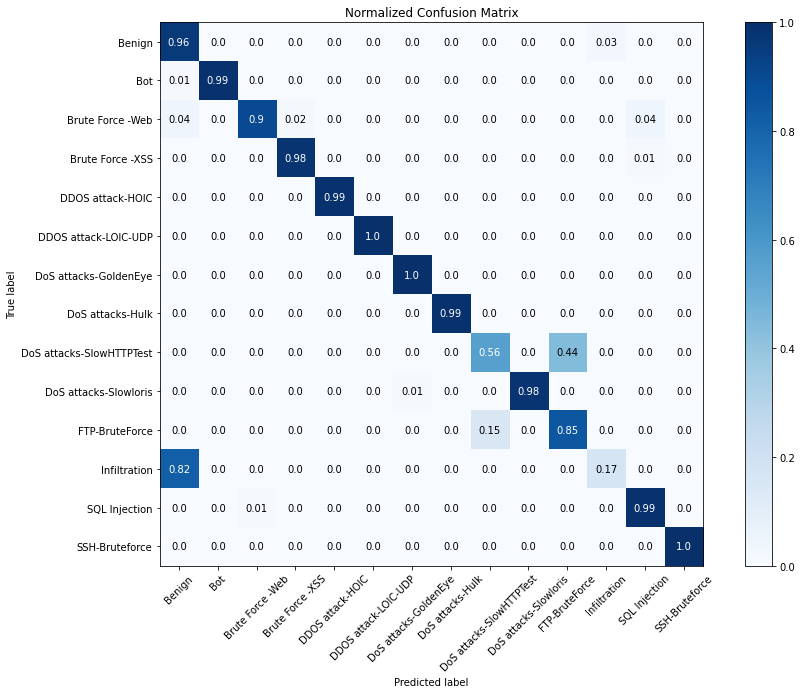

In [ ]:
cm(X, Y)

Model still has trouble with infiltration attacks, but we have overall improvement.

### Binary Classification

In [ ]:
balanced_dfb = balanced_df.copy()

In [ ]:
balanced_dfb.Label = balanced_dfb.Label.apply(binarize_events)

In [ ]:
balanced_dfb.Label.value_counts()

Malicious    5198
Benign       3981
Name: Label, dtype: int64

In [ ]:
X = balanced_dfb.drop(columns=['Label'])
Y = balanced_dfb.Label

In [ ]:
start_time = time.time()
baseline_test(X, Y, 'ALL')
print("--- %s seconds total ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP train accuracy: 0.897453356938581
MLP test accuracy:  0.8927015250544662
MLP train f1 score: 0.897447724288944
MLP test f1 score:  0.8926933833458536
MLP train log loss: 0.2507064213117707
MLP test log loss:  0.26389233497583275
MLP time:           10.402048349380493 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR  train accuracy: 0.7592264741931091
LR  test accuracy:  0.7690631808278867
LR  train f1 score: 0.7602233236946866
LR  test f1 score:  0.7701201579477588
LR  train log loss: 0.5339450482230732
LR  test log loss:  0.5859839364278765
LR  time:           0.4118833541870117 

RFC train accuracy: 0.9998638158790685
RFC test accuracy:  0.9482570806100218
RFC train f1 score: 0.9998638183618496
RFC test f1 score:  0.948410095706298
RFC train log loss: 0.033272852598340404
RFC test log loss:  0.15648805166410445
RFC time:           1.758302927017212 

KNN train accuracy: 0.9478414816832358
KNN test accuracy:  0.9302832244008714
KNN train f1 score: 0.947959557037662
KNN test f1 score:  0.9304592559083736
KNN train log loss: 0.10843902348973819
KNN test log loss:  1.061918093076091
KNN time:           1.2189929485321045 

--- 13.795009851455688 seconds total ---


<Figure size 1080x720 with 0 Axes>

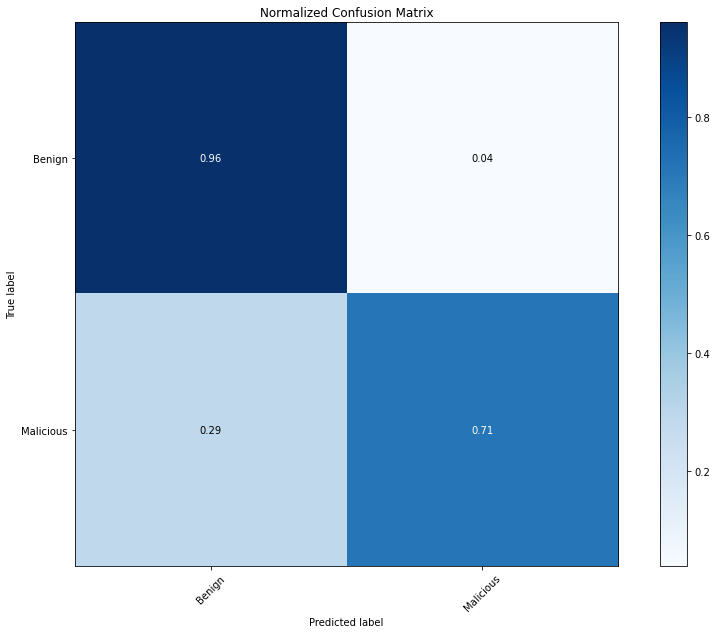

In [ ]:
cm(X, Y)

Significant improvement with binary classification as well.

Let's try tuning our models to see if we can increase performance even further.

## Parameter Tuning

In [ ]:
def tune(X, Y, model, params, name):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
    print("The number of observations in training set is {}".format(X_train.shape[0]))
    print("The number of observations in test set is {}".format(X_test.shape[0]))
    print('')

    rs = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter = 50, cv = 3, verbose = 1, n_jobs = -1, random_state=42)
    rs.fit(X_train, y_train)

    print('')
    print('Best score:', rs.best_score_)
    print('')
    print('Best params:', rs.best_params_)
    print('')

    model_results(X, Y, rs, 'Best {} grid'.format(name))

### Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)

In [ ]:
rfc_params = {'n_estimators': np.arange(100, 1050, 50),
              'max_depth':  np.arange(2, 30),
              'min_samples_split': [2,5,7,10,12,15,17,20],
              'min_samples_leaf': [2,5,7,10,12,15,17,20],
              'max_features': ['auto', 'sqrt', 'log2'],
              'bootstrap': [True, False]
}

#### Tune Binary

In [ ]:
X = dfb.drop(columns=['Label'])
Y = dfb.Label

In [ ]:
tune(X, Y, rfc, rfc_params, 'RFC')

The number of observations in training set is 6777
The number of observations in test set is 1695

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
# best parameters
rfc = RandomForestClassifier(bootstrap=False, max_depth=22, max_features='auto',
                                 min_samples_leaf=2, min_samples_split=15,
                                 n_estimators=300, random_state=42)

In [ ]:
cross_val_score(rfc, X, Y, cv=10)

In [ ]:
model_results(X, Y, rfc, 'RFC')

In [ ]:
cmm(X, Y, rfc)

#### Tune Classification

In [ ]:
X = df.drop(columns=['Label'])
Y = df.Label

In [ ]:
tune(X, Y, rfc, rfc_params, 'RFC')

In [ ]:
# best parameters
rfc = RandomForestClassifier(bootstrap=True, max_depth=18, max_features='sqrt',
                                 min_samples_leaf=2, min_samples_split=20,
                                 n_estimators=1000, random_state=42)

In [ ]:
cross_val_score(rfc, X, Y, cv=10)

In [ ]:
model_results(X, Y, rfc, 'RFC')

In [ ]:
cmm(X, Y, rfc)

### Multilayer Perceptron

In [ ]:
mlp = MLPClassifier(random_state=42)

In [ ]:
mlp_params = {'max_iter': np.arange(50, 350, 50),
              'hidden_layer_sizes': [x for x in itertools.product((10,20,30,40,50,100), repeat=2)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],
              'learning_rate': ['constant','adaptive'],
}

#### Tune Binary

In [ ]:
X = dfb.drop(columns=['Label'])
Y = dfb.Label

In [ ]:
tune(X, Y, mlp, mlp_params, 'MLP')

In [ ]:
# best parameters
mlp = MLPClassifier(solver='adam', max_iter=150, learning_rate='adaptive',
                    hidden_layer_sizes=(50,100), alpha=0.0001,
                    activation='relu', random_state=42)

In [ ]:
cross_val_score(mlp, X, Y, cv=10)

In [ ]:
model_results(X, Y, mlp, 'MLP')

In [ ]:
cmm(X, Y, mlp)

#### Tune Classification

In [ ]:
X = df.drop(columns=['Label'])
Y = df.Label

In [ ]:
tune(X, Y, mlp, mlp_params, 'MLP')

In [ ]:
# best parameters
mlp = MLPClassifier(solver='adam', max_iter=300, learning_rate='constant',
                    hidden_layer_sizes=(50,50), alpha=0.0001,
                    activation='relu', random_state=42)

In [ ]:
cross_val_score(mlp, X, Y, cv=10)

In [ ]:
model_results(X, Y, mlp, 'MLP')

In [ ]:
cmm(X, Y, mlp)

### Gradient Boosting

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

In [ ]:
gbc_params = {"loss":["deviance", "exponential"],
              "learning_rate": [0.15,0.1,0.05,0.01,0.005,0.001],
              "min_samples_split": [2,4,6,8,10,20,40,60,100],
              "min_samples_leaf": [1,3,5,7,9],
              "max_depth":[2,3,4,5,6,7],
              "max_features":["log2","sqrt"],
              "criterion": ["friedman_mse", "mse", "mae"],
              "subsample":[0.7,0.75,0.8,0.85,0.9,0.95,1],
              "n_estimators":[50,100,250,500,750,1000,1250,1500,1750]
              }

#### Tune Binary

In [ ]:
X = dfb.drop(columns=['Label'])
Y = dfb.Label

In [ ]:
tune(X, Y, gbc, gbc_params, 'GBC')

In [ ]:
# best parameters
gbc = GradientBoostingClassifier(subsample=1, n_estimators=500, min_samples_split=20,
                                 min_samples_leaf=7, max_features='log2', max_depth=4,
                                 loss='exponential', learning_rate=0.05, criterion='mse',
                                 random_state=42)

In [ ]:
cross_val_score(gbc, X, Y, cv=10)

In [ ]:
model_results(X, Y, gbc, 'GBC')

In [ ]:
cmm(X, Y, gbc)

#### Tune Classification

In [ ]:
X = df.drop(columns=['Label'])
Y = df.Label

In [ ]:
tune(X, Y, gbc, gbc_params, 'GBC')

In [ ]:
# best parameters
gbc = GradientBoostingClassifier(subsample=0.85, n_estimators=250, min_samples_split=6,
                                 min_samples_leaf=9, max_features='log2', max_depth=5,
                                 loss='deviance', learning_rate=0.05, criterion='mae',
                                 random_state=42)

In [ ]:
cross_val_score(gbc, X, Y, cv=10)

In [ ]:
model_results(X, Y, gbc, 'GBC')

In [ ]:
cmm(X, Y, gbc)

# Conclusion

## Summary

*   One of the main challenges was the size of the data, at 3GB+ and 8M+ rows
 *   To circumvent this issue, Google’s Datalab was used as well as PySpark/Databricks to show a distributed system solution
* Overall, the models performed very well, achieving > 90% accuracy in most scenarios
* There are some threat types that are more difficult to predict than others, namely infiltration, which is worth investigating further
* When excluding these threats, the models run with great accuracy, meaning they can be used reliably in scenarios where these threats are expected
 * Certain threats such as Botnet, BruteForce and DDoS can be predicted with nearly 100% accuracy

## Further Optimization

* Improve model’s accuracy with identifying certain attacks, namely infiltration
 * May need to collect and include additional data tailored to these attacks to improve performance
* Random forest was the most accurate model during testing, however, better results may be possible using more advanced deep learning techniques
 * Would like to learn and implement Tensorflow models
* Dive deeper into the existing features of each attack to further understand why certain attacks are more difficult to identify
* Timestamp was removed before modelling, but there may be some correlation between timeframes and attack types
* More in-depth parameter tuning